In [53]:
from __future__ import print_function, division
from math import log, exp, sqrt, sin, cos, pi
import numpy as np
from numpy import split, array, arctan, mean, zeros, sin, cos, pi, arange, concatenate

import pandas as pd

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import tensorflow
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, LSTM, Conv1D, Input, Add, Activation, Dropout
from tensorflow.keras.layers import LeakyReLU, ELU
from tensorflow.python.keras.layers import RepeatVector, TimeDistributed, Bidirectional, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras import optimizers


import matplotlib
from matplotlib import pyplot

pyplot.style.use('ggplot')

from IPython.display import Image 
import datetime, os

# Load the TensorBoard notebook extension
#%load_ext tensorboard
pyplot.rcParams['figure.dpi'] = 100
pyplot.rcParams['figure.figsize'] = [12,5]
matplotlib.rc('lines', linewidth=1, linestyle='-')

In [54]:
def DC_CNN_Block(nb_filter, filter_length, dilation, l2_layer_reg):
    def f(input_):
        
        residual =    input_

        layer_out =   Conv1D(filters=nb_filter, kernel_size=filter_length, dilation_rate=dilation, activation='linear', padding='causal', use_bias=False)(input_)
                      #, kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=42), kernel_regularizer=l2(l2_layer_reg)
                    
        layer_out =   Activation('selu')(layer_out)
        
        skip_out =    Conv1D(1,1, activation='linear', use_bias=False)(layer_out) 
                      #, kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=42), kernel_regularizer=l2(l2_layer_reg)
        
        network_in =  Conv1D(1,1, activation='linear', use_bias=False)(layer_out) 
                      #, kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=42), kernel_regularizer=l2(l2_layer_reg)
        
        network_out = Add()([residual, network_in])
        
        return network_out, skip_out
    
    return f

In [55]:
# r = 8, L=3, K=2
"""
def build_model(train, length):
    # prepare data
    train_x, train_y = to_supervised(train, length)
    input = Input(shape=(length,1))
    
    l1a, l1b = DC_CNN_Block(32,2,1,0.001)(input)    
    l2a, l2b = DC_CNN_Block(32,2,2,0.001)(l1a)
    l2b = Dropout(0.4)(l2b) #dropout used to limit influence of earlier data
    l3a, l3b = DC_CNN_Block(32,2,4,0.001)(l2a)
    l3b = Dropout(0.4)(l3b) #dropout used to limit influence of earlier data

    l4 =   Add()([l1b, l2b, l3b])
    
    l5 =   Activation('relu')(l4)
           
    l21 =  Conv1D(1,1, activation='linear', use_bias=False)(l5)
    #, kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=42), kernel_regularizer=l2(0.001)
    model = Model(input, l21)
    
    adam = optimizers.Adam(lr=0.0075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) 
    #lr=0.0075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False
                    

    model.compile(loss='mae', optimizer=adam, metrics=['mse'])
    
    early = tensorflow.keras.callbacks.EarlyStopping('loss', patience=500)
    print(model.summary())
    history = model.fit(train_x, train_y, epochs=8000, callbacks=[early], verbose=1)  
    pyplot.plot(history.history['loss'])
    pyplot.show()
    return model
"""

#r = 32, L=5, K=2

"""
def build_model(train, length):
    # prepare data
    train_x, train_y = to_supervised(train, length)
    input = Input(shape=(length,1))
    
    l1a, l1b = DC_CNN_Block(32,2,1,0.001)(input)    
    l2a, l2b = DC_CNN_Block(32,2,2,0.001)(l1a) 
    l3a, l3b = DC_CNN_Block(32,2,4,0.001)(l2a)
    l4a, l4b = DC_CNN_Block(32,2,8,0.001)(l3a)
    l4b = Dropout(0.4)(l4b) #dropout used to limit influence of earlier data
    l5a, l5b = DC_CNN_Block(32,2,16,0.001)(l4a)
    l5b = Dropout(0.4)(l5b) #dropout used to limit influence of earlier data

    l6 =   Add()([l1b, l2b, l3b, l4b, l5b])
    
    l7 =   Activation('relu')(l6)
           
    l21 =  Conv1D(1,1, activation='linear', use_bias=False)(l7)
    #, kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=42), kernel_regularizer=l2(0.001)
    model = Model(input, l21)
    
    adam = optimizers.Adam(lr=0.0075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) 
    #lr=0.0075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False
                    

    model.compile(loss='mae', optimizer=adam, metrics=['mse'])
    
    early = tensorflow.keras.callbacks.EarlyStopping('loss', patience=500)
    print(model.summary())
    history = model.fit(train_x, train_y, epochs=8000, callbacks=[early], verbose=1)  
    pyplot.plot(history.history['loss'])
    pyplot.show()
    return model
"""

# r = 128, L=7, K=2 ---> original!


def build_model(train, length):
    # prepare data
    train_x, train_y = to_supervised(train, length)
    input = Input(shape=(length,1))
    
    l1a, l1b = DC_CNN_Block(32,2,1,0.001)(input)    
    l2a, l2b = DC_CNN_Block(32,2,2,0.001)(l1a) 
    l3a, l3b = DC_CNN_Block(32,2,4,0.001)(l2a)
    l4a, l4b = DC_CNN_Block(32,2,8,0.001)(l3a)
    l5a, l5b = DC_CNN_Block(32,2,16,0.001)(l4a)
    l6a, l6b = DC_CNN_Block(32,2,32,0.001)(l5a)
    l6b = Dropout(0.8)(l6b) #dropout used to limit influence of earlier data
    l7a, l7b = DC_CNN_Block(32,2,64,0.001)(l6a)
    l7b = Dropout(0.8)(l7b) #dropout used to limit influence of earlier data

    l8 =   Add()([l1b, l2b, l3b, l4b, l5b, l6b, l7b])
    
    l9 =   Activation('relu')(l8)
           
    l21 =  Conv1D(1,1, activation='linear', use_bias=False)(l9)
    #, kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=42), kernel_regularizer=l2(0.001)
    model = Model(input, l21)
    
    adam = optimizers.Adam(lr=0.0075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) 
    #lr=0.0075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False
                    

    model.compile(loss='mae', optimizer=adam, metrics=['mse'])
    
    early = tensorflow.keras.callbacks.EarlyStopping('loss', patience=500)
    print(model.summary())
    history = model.fit(train_x, train_y, epochs=8000, callbacks=[early], verbose=1)  
    pyplot.plot(history.history['loss'])
    pyplot.show()
    return model


#r = 256, L=8, K = 2

"""
def build_model(train, length):
    # prepare data
    train_x, train_y = to_supervised(train, length)
    input = Input(shape=(length,1))
    
    l1a, l1b = DC_CNN_Block(32,2,1,0.001)(input)    
    l2a, l2b = DC_CNN_Block(32,2,2,0.001)(l1a) 
    l3a, l3b = DC_CNN_Block(32,2,4,0.001)(l2a)
    l4a, l4b = DC_CNN_Block(32,2,8,0.001)(l3a)
    l5a, l5b = DC_CNN_Block(32,2,16,0.001)(l4a)
    l6a, l6b = DC_CNN_Block(32,2,32,0.001)(l5a)
    l7a, l7b = DC_CNN_Block(32,2,64,0.001)(l6a)
    l7b = Dropout(0.8)(l7b) #dropout used to limit influence of earlier data
    l8a, l8b = DC_CNN_Block(32,2,128,0.001)(l7a)
    l8b = Dropout(0.8)(l8b) #dropout used to limit influence of earlier data
    
    l9 =   Add()([l1b, l2b, l3b, l4b, l5b, l6b, l7b, l8b])
    
    l10 =   Activation('relu')(l9)
           
    l21 =  Conv1D(1,1, activation='linear', use_bias=False)(l10)
    #, kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=42), kernel_regularizer=l2(0.001)
    model = Model(input, l21)
    
    adam = optimizers.Adam(lr=0.0075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) 
    #lr=0.0075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False
                    

    model.compile(loss='mae', optimizer=adam, metrics=['mse'])
    
    early = tensorflow.keras.callbacks.EarlyStopping('loss', patience=500)
    print(model.summary())
    history = model.fit(train_x, train_y, epochs=8000, callbacks=[early], verbose=1)  
    pyplot.plot(history.history['loss'])
    pyplot.show()
    return model
"""

#r = 768 , L=9, K=3

"""
def build_model(train, length):
    # prepare data
    train_x, train_y = to_supervised(train, length)
    input = Input(shape=(length,1))
    
    l1a, l1b = DC_CNN_Block(32,3,1,0.001)(input)    
    l2a, l2b = DC_CNN_Block(32,3,2,0.001)(l1a) 
    l3a, l3b = DC_CNN_Block(32,3,4,0.001)(l2a)
    l4a, l4b = DC_CNN_Block(32,3,8,0.001)(l3a)
    l5a, l5b = DC_CNN_Block(32,3,16,0.001)(l4a)
    l6a, l6b = DC_CNN_Block(32,3,32,0.001)(l5a)
    l7a, l7b = DC_CNN_Block(32,3,64,0.001)(l6a)
    l8a, l8b = DC_CNN_Block(32,3,128,0.001)(l7a)
    l8b = Dropout(0.8)(l8b) #dropout used to limit influence of earlier data
    l9a, l9b = DC_CNN_Block(32,3,256,0.001)(l8a)
    l9b = Dropout(0.8)(l9b) #dropout used to limit influence of earlier data
    
    l10 =   Add()([l1b, l2b, l3b, l4b, l5b, l6b, l7b, l8b, l9b])
    
    l11 =   Activation('relu')(l10)
           
    l21 =  Conv1D(1,1, activation='linear', use_bias=False)(l11)
    #, kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=42), kernel_regularizer=l2(0.001)
    model = Model(input, l21)
    
    adam = optimizers.Adam(lr=0.0075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) 
    #lr=0.0075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False
                    

    model.compile(loss='mae', optimizer=adam, metrics=['mse'])
    
    early = tensorflow.keras.callbacks.EarlyStopping('loss', patience=500)
    print(model.summary())
    history = model.fit(train_x, train_y, epochs=8000, callbacks=[early], verbose=1)  
    pyplot.plot(history.history['loss'])
    pyplot.show()
    return model
"""

"\ndef build_model(train, length):\n    # prepare data\n    train_x, train_y = to_supervised(train, length)\n    input = Input(shape=(length,1))\n    \n    l1a, l1b = DC_CNN_Block(32,3,1,0.001)(input)    \n    l2a, l2b = DC_CNN_Block(32,3,2,0.001)(l1a) \n    l3a, l3b = DC_CNN_Block(32,3,4,0.001)(l2a)\n    l4a, l4b = DC_CNN_Block(32,3,8,0.001)(l3a)\n    l5a, l5b = DC_CNN_Block(32,3,16,0.001)(l4a)\n    l6a, l6b = DC_CNN_Block(32,3,32,0.001)(l5a)\n    l7a, l7b = DC_CNN_Block(32,3,64,0.001)(l6a)\n    l8a, l8b = DC_CNN_Block(32,3,128,0.001)(l7a)\n    l8b = Dropout(0.8)(l8b) #dropout used to limit influence of earlier data\n    l9a, l9b = DC_CNN_Block(32,3,256,0.001)(l8a)\n    l9b = Dropout(0.8)(l9b) #dropout used to limit influence of earlier data\n    \n    l10 =   Add()([l1b, l2b, l3b, l4b, l5b, l6b, l7b, l8b, l9b])\n    \n    l11 =   Activation('relu')(l10)\n           \n    l21 =  Conv1D(1,1, activation='linear', use_bias=False)(l11)\n    #, kernel_initializer=TruncatedNormal(mean=0.0, 

In [56]:
#%reload_ext tensorboard

In [57]:
# MAAPE metric -> does not have the same behaviour as MAPE for actual values close to zero, which is good

def mean_arctangent_absolute_percentage_error(actual, predicted):

    return mean(arctan(abs((actual - predicted) / actual))) * 100

In [58]:
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    # Plot rolling statistics:
    orig = pyplot.plot(timeseries, color='blue', label='Original')
    mean = pyplot.plot(rolmean, color='red', label='Rolling Mean')
    std = pyplot.plot(rolstd, color='black', label='Rolling Std')
    pyplot.legend(loc='best')
    pyplot.title('Rolling Mean & Standard Deviation')
    pyplot.show(block=False) 

    # Perform the augmented Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [59]:
# load the csv file
# ../old_data//30min/30minstore290.csv
# ../old_data/30min/30minstore1027.csv
# ../30min/30minstore274.csv
# special case01: ../old_data/30min/partial_covid_stationary_sliced_30minstore274.csv
# special case02: ../old_data/30min/full_covid_nonstationary_sliced_30minstore274.csv
# predict covid:  ../old_data/30min/predict_covid_30minstore274


# NEW STORES
# ../Treatment/imputed_stores/linear_interp_store0057.csv
# ../Treatment/new_stores/store_0057.csv

# ../Treatment/imputed_stores/linear_interp_store4969.csv
# ../Treatment/new_stores/store_4969.csv

# ../Treatment/imputed_stores/linear_interp_store0018.csv
# ../Treatment/new_stores/store_0018.csv


# IMPUTED DATASET
dataset = pd.read_csv('../Treatment/imputed_stores/linear_interp_store4969.csv', header=0, infer_datetime_format=True,parse_dates=['ds'], index_col=['ds'])

# NORMAL DATASET
#dataset = pd.read_csv('../Treatment/new_stores/store_4969.csv', header=0, infer_datetime_format=True,parse_dates=['ds'], index_col=['ds'])
print(dataset)

                      sales  n_clients imputed
ds                                            
2017-06-12 09:00:00    3.00        2.0     yes
2017-06-12 09:30:00    3.00        2.0     yes
2017-06-12 10:00:00    3.00        2.0     yes
2017-06-12 10:30:00    3.00        2.0     yes
2017-06-12 11:00:00    3.00        2.0     yes
...                     ...        ...     ...
2020-10-18 19:00:00  103.44       22.0      no
2020-10-18 19:30:00  162.26       35.0      no
2020-10-18 20:00:00  138.26       24.0      no
2020-10-18 20:30:00   53.57       16.0      no
2020-10-18 21:00:00   17.00        2.0      no

[24400 rows x 3 columns]


In [60]:
# PARAMETERS
test_set = 750               # last observations for the test_set
n_output = test_set
n_test_sets = 3              # how many times tests to do, this is relevant to the walkforward validation
init_train_set = 400           # refers to when the train_set starts
# A:725 B:400 C:450 (STD/STD+HR)
walkforward = True           # walkforward validation 
encode_weekday = False       # If the string weekday is included in the dataset
imputed = True               # If data was imputed, False if the data was not imputed
compare_imputed = False        # If the results are to be compared to an imputed version, False if we're not trying to compare
# Remove seasonality (and trend if necessary)
remove_components = False

if n_test_sets>1:
    walkforward = True


    
print("Train beginning:\n")
print(dataset.iloc[init_train_set])
dataset = dataset.iloc[init_train_set:]
print("\nTrain end:\n")
print(dataset.iloc[-test_set*n_test_sets-1])
print("\nTest beggining:\n")
print(dataset.iloc[-test_set*n_test_sets])
print("\nTest end:\n")
print(dataset.iloc[-1])

if imputed:
    # if imputed is true this will be used; its to remove hours that cannot be compared with an imputed model
    imputed_idx = np.where(dataset.imputed=="yes")[0].tolist()
elif compare_imputed:
    # if compare_imputed is true this will be used; its to remove hours that cannot be compared with an imputed model
    remove_idx = dataset.between_time('21:01', '08:59')
    remove_idx = np.where(dataset.index.isin(remove_idx.index))[0].tolist()
    
# Univariate
dataset = dataset[['n_clients']]
dataset = dataset.astype('int64')
train_dataset = dataset.iloc[:-test_set*n_test_sets]
n_features = len(dataset.columns)
print(dataset, n_features)

print("This is the recursive mode.")

Train beginning:

sales        23.81
n_clients     11.0
imputed         no
Name: 2017-07-08 09:00:00, dtype: object

Train end:

sales        7.0
n_clients    1.0
imputed       no
Name: 2020-07-19 21:00:00, dtype: object

Test beggining:

sales        29.38
n_clients      9.0
imputed         no
Name: 2020-07-20 09:00:00, dtype: object

Test end:

sales        17.0
n_clients     2.0
imputed        no
Name: 2020-10-18 21:00:00, dtype: object
                     n_clients
ds                            
2017-07-08 09:00:00         11
2017-07-08 09:30:00         10
2017-07-08 10:00:00         14
2017-07-08 10:30:00          8
2017-07-08 11:00:00         24
...                        ...
2020-10-18 19:00:00         22
2020-10-18 19:30:00         35
2020-10-18 20:00:00         24
2020-10-18 20:30:00         16
2020-10-18 21:00:00          2

[24000 rows x 1 columns] 1
This is the recursive mode.


10876 9131.310000000001 2.381914533621134


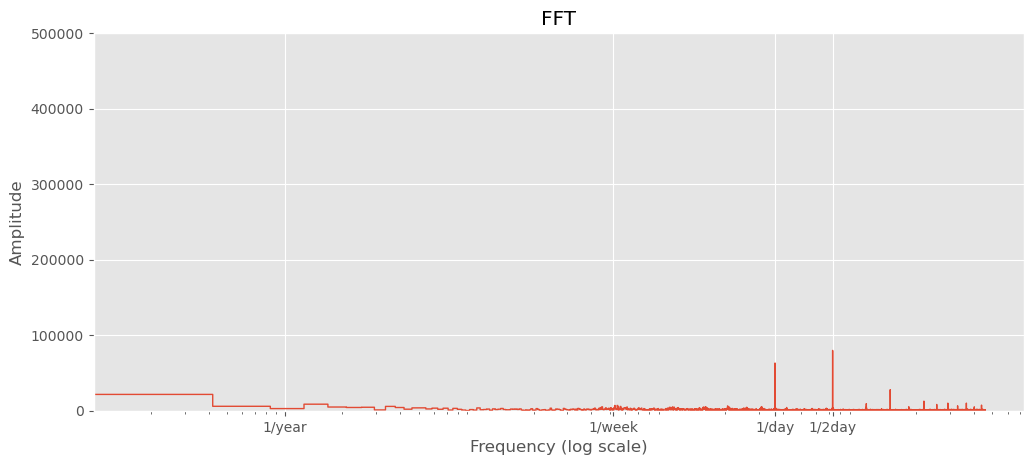

In [61]:
# FFT: Finding relevant seasonalities in high-frequency data
# Configurable: in the Chapter example, a day is 25 half hours
dataset_day = 25

fft = tensorflow.signal.rfft(train_dataset['n_clients'])
f_per_dataset = arange(0, len(fft))

n_samples_h = len(train_dataset['n_clients'])
days_per_year = dataset_day*365.2524
years_per_dataset = n_samples_h/(days_per_year)

print(len(fft), days_per_year, years_per_dataset)

f_per_year = f_per_dataset/years_per_dataset
pyplot.step(f_per_year, np.abs(fft))
pyplot.title("FFT")
pyplot.xscale('log')
pyplot.ylim(0, 500000)
pyplot.xlim([0.1, max(pyplot.xlim())])
pyplot.xticks([1, 52.1428571429, 365.2524, 730.5048], labels=['1/year', '1/week', '1/day', '1/2day'])
_ = pyplot.xlabel('Frequency (log scale)')
pyplot.ylabel('Amplitude')
pyplot.show()

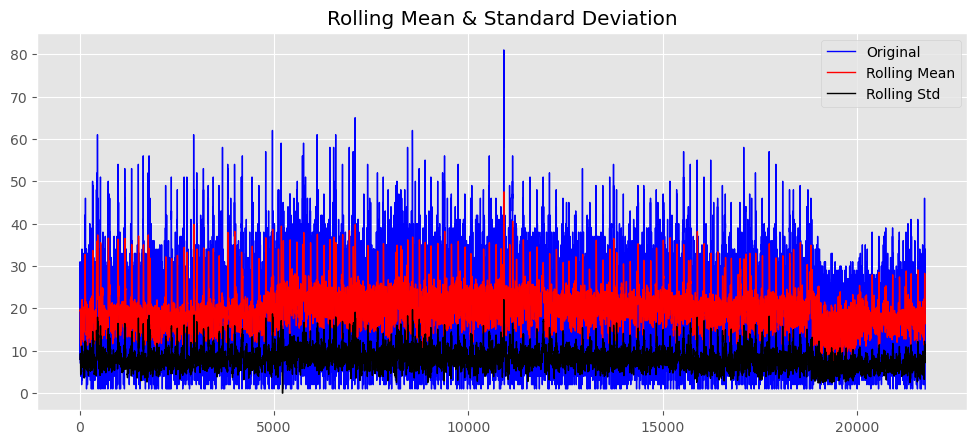

Results of Dickey-Fuller Test:
Test Statistic                -1.427036e+01
p-value                        1.377644e-26
#Lags Used                     4.700000e+01
Number of Observations Used    2.170200e+04
Critical Value (1%)           -3.430651e+00
Critical Value (5%)           -2.861673e+00
Critical Value (10%)          -2.566841e+00
dtype: float64


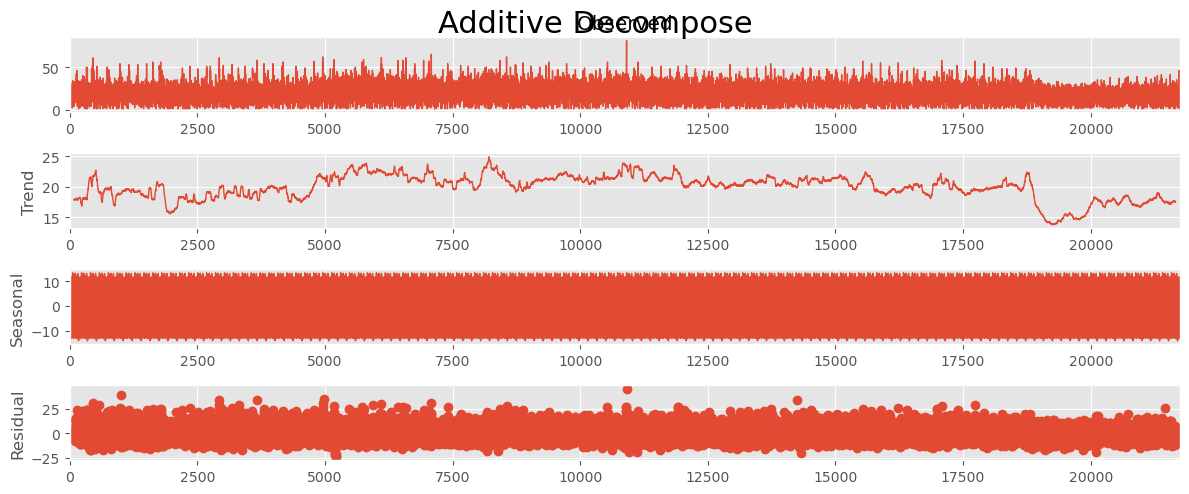

In [62]:
# Check components and stationarity of the forecast variable
forecast_variable = train_dataset['n_clients'].values

# Test stationarity
test_stationarity(forecast_variable)

# Additive Decomposition
result_add = seasonal_decompose(forecast_variable, model='additive', period=175)

# Plot components

result_add.plot().suptitle('Additive Decompose', fontsize=22)
pyplot.show()

In [63]:
#%matplotlib notebook
if remove_components:
    # Remove trend and seasonality, regression with fourier terms!
    forecast_variable = train_dataset.reset_index().drop(['ds'],axis=1)
    print(forecast_variable)

    # Time scale
    predic1 = range(len(train_dataset))
    model_day = True
    model_halfday = True
    model_week = False
    
    # K = 1
    if model_halfday:
        predic_halfday_cos = list(map(lambda x: cos(2*pi*x/(dataset_day/2.0)), predic1))
        predic_halfday_sin = list(map(lambda x: sin(2*pi*x/(dataset_day/2.0)), predic1))
    if model_day:
        #Applying the Fourier terms to the time scale
        predic_day_cos = list(map(lambda x: cos(2*pi*x/dataset_day), predic1))
        predic_day_sin = list(map(lambda x: sin(2*pi*x/dataset_day), predic1))
    if model_week:
        predic_week_cos = list(map(lambda x: cos(2*pi*x/(dataset_day*7)), predic1))
        predic_week_sin = list(map(lambda x: sin(2*pi*x/(dataset_day*7)), predic1))
    
    # Assembling the regressors
    if model_halfday and model_day and model_week: 
        reg = pd.DataFrame(list(zip(predic1, predic_day_cos, predic_day_sin, predic_week_cos, predic_week_sin, predic_halfday_cos, predic_halfday_sin)), 
                columns =['predic1', 'predic_day_cos', 'predic_day_sin', 'predic_week_cos', 'predic_week_sin', 'predic_halfday_cos', 'predic_halfday_sin'])

        # Linear regression
        reg_model = LinearRegression().fit(reg, forecast_variable)

        #The estimated parameters
        r2 = reg_model.score(reg, forecast_variable)
        print('coefficient of determination:', r2)

        trend = reg_model.intercept_ + reg_model.coef_[0][0]*array(predic1)
        seas_day = reg_model.coef_[0][1]*array(predic_day_cos) + reg_model.coef_[0][2]*array(predic_day_sin)
        seas_week = reg_model.coef_[0][3]*array(predic_week_cos) + reg_model.coef_[0][4]*array(predic_week_sin)
        seas_halfday = reg_model.coef_[0][5]*array(predic_halfday_cos) + reg_model.coef_[0][6]*array(predic_halfday_sin)
        trend_seas = trend + seas_day  + seas_week + seas_halfday
    elif model_halfday and model_day and not model_week:
        reg = pd.DataFrame(list(zip(predic1, predic_day_cos, predic_day_sin, predic_halfday_cos, predic_halfday_sin)), 
                columns =['predic1', 'predic_day_cos', 'predic_day_sin', 'predic_halfday_cos', 'predic_halfday_sin'])

        # Linear regression
        reg_model = LinearRegression().fit(reg, forecast_variable)

        #The estimated parameters
        r2 = reg_model.score(reg, forecast_variable)
        print('coefficient of determination:', r2)

        trend = reg_model.intercept_ + reg_model.coef_[0][0]*array(predic1)
        seas_day = reg_model.coef_[0][1]*array(predic_day_cos) + reg_model.coef_[0][2]*array(predic_day_sin)
        seas_halfday = reg_model.coef_[0][3]*array(predic_halfday_cos) + reg_model.coef_[0][4]*array(predic_halfday_sin)
        trend_seas = trend + seas_day  + seas_halfday
    elif not model_halfday and model_day and model_week:
        reg = pd.DataFrame(list(zip(predic1, predic_day_cos, predic_day_sin, predic_week_cos, predic_week_sin)), 
                columns =['predic1', 'predic_day_cos', 'predic_day_sin', 'predic_week_cos', 'predic_week_sin'])

        # Linear regression
        reg_model = LinearRegression().fit(reg, forecast_variable)

        #The estimated parameters
        r2 = reg_model.score(reg, forecast_variable)
        print('coefficient of determination:', r2)

        trend = reg_model.intercept_ + reg_model.coef_[0][0]*array(predic1)
        seas_day = reg_model.coef_[0][1]*array(predic_day_cos) + reg_model.coef_[0][2]*array(predic_day_sin)
        seas_week = reg_model.coef_[0][3]*array(predic_week_cos) + reg_model.coef_[0][4]*array(predic_week_sin)
        trend_seas = trend + seas_day  + seas_week

    

    ax = pd.DataFrame(trend_seas, columns=['trend+seasonalities']).plot(figsize=(20,8))
    forecast_variable.plot(ax=ax,alpha=0.7)

    y_adjusted = array(list(forecast_variable['n_clients'])) - trend_seas
    y_adjusted = pd.DataFrame(y_adjusted, columns=['noise'])
    y_adjusted.plot(figsize=(20,8))
    
    y_adjusted = y_adjusted.set_index(train_dataset.index)
    frames = [train_dataset.assign(n_clients=y_adjusted['noise']), dataset.iloc[-test_set*n_test_sets:]]
    dataset = pd.concat(frames)
    print(dataset)

In [64]:
values = dataset.values
# Encode weekday
if encode_weekday:
    encoder = LabelEncoder()
    values[:, 1] = encoder.fit_transform(values[:, 1])

# ensure all data is float
values = values.astype('float32')

print(values.shape)

(24000, 1)


In [65]:
# split into train and test, leave the last test_set blocks for n_output timesteps
train, test = values[:-test_set*n_test_sets], values[-test_set*n_test_sets:]  

# Normalization
#scaler = StandardScaler() #MinMaxScaler(feature_range=(0, 1)) 
#train = scaler.fit_transform(train)
#test = scaler.transform(test)

#for walkforward
def normalize_train(scaler, train):
    train = scaler.fit_transform(train)
    return train

print(train.shape, test.shape)

(21750, 1) (2250, 1)


In [66]:
# convert history into inputs and outputs - framing to a supervised learning problem
def to_supervised(train, length):
    train = train[~pd.isna(train)]
    train = np.atleast_2d(np.asarray(train))
    if train.shape[0] == 1:
        train = train.T 
    train_x = train[:-1].reshape(1,length,1)
    train_y = train[1:].reshape(1,length,1)

    print(train_x.shape, train_y.shape)
    return train_x, train_y

In [67]:
# make the multi-step forecast
def forecast(model, train, length):
    
    pred_array = np.zeros(test_set).reshape(1,test_set,1)
    X_test_initial = train[1:].reshape(1,length,1)
    #pred_array = model.predict(X_test_initial) if predictions of training samples required
    
    #forecast is created by predicting next future value based on previous predictions
    #print(model.predict(X_test_initial))
    pred_array[:,0,:] = model.predict(X_test_initial)[:,-1:,:]
    
    
    for i in range(test_set-1):
        appending = np.append(X_test_initial[:,i+1:,:],pred_array[:,:i+1,:])
        #print("appending")
        #print(appending.flatten(), appending.shape)
        
        pred = model.predict(appending.reshape(1, length, 1))
        #print("prediction\n")
        #print(pred.flatten(), pred.shape)
        
        pred_array[:,i+1:,:] = pred[:,-1:,:]

    
    return pred_array.flatten()

In [68]:
# invert the scaling
def invTransformTarget(scaler, data):
    dummy = pd.DataFrame(zeros((len(data), scaler.n_features_in_)))
    dummy[0] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=dummy.columns)
    return dummy[0].values

walkforward expanding: 1
total expansions: 3
(1, 21749, 1) (1, 21749, 1)
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 21749, 1)]   0                                            
__________________________________________________________________________________________________
conv1d_110 (Conv1D)             (None, 21749, 32)    64          input_6[0][0]                    
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 21749, 32)    0           conv1d_110[0][0]                 
__________________________________________________________________________________________________
conv1d_112 (Conv1D)             (None, 21749, 1)     32          activation_40[0][0]              
___________________

1/1 [==============================] - 1s 1s/step - loss: 18.1862 - mse: 430.3673
Epoch 2/8000
1/1 [==============================] - 0s 80ms/step - loss: 15.0506 - mse: 321.2347
Epoch 3/8000
1/1 [==============================] - 0s 81ms/step - loss: 12.5286 - mse: 230.4225
Epoch 4/8000
1/1 [==============================] - 0s 82ms/step - loss: 11.0434 - mse: 191.7267
Epoch 5/8000
1/1 [==============================] - 0s 88ms/step - loss: 10.1213 - mse: 172.1638
Epoch 6/8000
1/1 [==============================] - 0s 82ms/step - loss: 8.9951 - mse: 132.3505
Epoch 7/8000
1/1 [==============================] - 0s 80ms/step - loss: 7.7355 - mse: 96.6489
Epoch 8/8000
1/1 [==============================] - 0s 78ms/step - loss: 7.0129 - mse: 80.2011
Epoch 9/8000
1/1 [==============================] - 0s 89ms/step - loss: 6.9580 - mse: 78.6903
Epoch 10/8000
1/1 [==============================] - 0s 89ms/step - loss: 6.8740 - mse: 76.2606
Epoch 11/8000
1/1 [==============================] - 

1/1 [==============================] - 0s 79ms/step - loss: 5.1377 - mse: 45.5182
Epoch 87/8000
1/1 [==============================] - 0s 77ms/step - loss: 5.1261 - mse: 45.3140
Epoch 88/8000
1/1 [==============================] - 0s 72ms/step - loss: 5.1238 - mse: 45.1244
Epoch 89/8000
1/1 [==============================] - 0s 83ms/step - loss: 5.1071 - mse: 44.9105
Epoch 90/8000
1/1 [==============================] - 0s 81ms/step - loss: 5.1218 - mse: 45.0114
Epoch 91/8000
1/1 [==============================] - 0s 84ms/step - loss: 5.1023 - mse: 44.7300
Epoch 92/8000
1/1 [==============================] - 0s 81ms/step - loss: 5.1025 - mse: 44.6433
Epoch 93/8000
1/1 [==============================] - 0s 79ms/step - loss: 5.0929 - mse: 44.5192
Epoch 94/8000
1/1 [==============================] - 0s 86ms/step - loss: 5.0914 - mse: 44.3955
Epoch 95/8000
1/1 [==============================] - 0s 80ms/step - loss: 5.0772 - mse: 44.2195
Epoch 96/8000
1/1 [==============================] - 0

1/1 [==============================] - 0s 100ms/step - loss: 4.8399 - mse: 39.4617
Epoch 171/8000
1/1 [==============================] - 0s 95ms/step - loss: 4.8450 - mse: 39.4455
Epoch 172/8000
1/1 [==============================] - 0s 100ms/step - loss: 4.8434 - mse: 39.5563
Epoch 173/8000
1/1 [==============================] - 0s 82ms/step - loss: 4.8432 - mse: 39.4945
Epoch 174/8000
1/1 [==============================] - 0s 86ms/step - loss: 4.8358 - mse: 39.3662
Epoch 175/8000
1/1 [==============================] - 0s 92ms/step - loss: 4.8345 - mse: 39.3950
Epoch 176/8000
1/1 [==============================] - 0s 104ms/step - loss: 4.8351 - mse: 39.3711
Epoch 177/8000
1/1 [==============================] - 0s 97ms/step - loss: 4.8373 - mse: 39.3587
Epoch 178/8000
1/1 [==============================] - 0s 87ms/step - loss: 4.8338 - mse: 39.2858
Epoch 179/8000
1/1 [==============================] - 0s 83ms/step - loss: 4.8288 - mse: 39.1567
Epoch 180/8000
1/1 [======================

1/1 [==============================] - 0s 94ms/step - loss: 4.7590 - mse: 38.2439
Epoch 255/8000
1/1 [==============================] - 0s 83ms/step - loss: 4.7460 - mse: 37.9264
Epoch 256/8000
1/1 [==============================] - 0s 82ms/step - loss: 4.7531 - mse: 38.0384
Epoch 257/8000
1/1 [==============================] - 0s 78ms/step - loss: 4.7491 - mse: 38.1296
Epoch 258/8000
1/1 [==============================] - 0s 85ms/step - loss: 4.7515 - mse: 38.0577
Epoch 259/8000
1/1 [==============================] - 0s 89ms/step - loss: 4.7483 - mse: 37.9915
Epoch 260/8000
1/1 [==============================] - 0s 79ms/step - loss: 4.7470 - mse: 38.1046
Epoch 261/8000
1/1 [==============================] - 0s 83ms/step - loss: 4.7437 - mse: 38.1038
Epoch 262/8000
1/1 [==============================] - 0s 89ms/step - loss: 4.7430 - mse: 37.9594
Epoch 263/8000
1/1 [==============================] - 0s 84ms/step - loss: 4.7442 - mse: 38.0919
Epoch 264/8000
1/1 [=========================

1/1 [==============================] - 0s 79ms/step - loss: 4.6907 - mse: 37.5594
Epoch 339/8000
1/1 [==============================] - 0s 84ms/step - loss: 4.6844 - mse: 37.4418
Epoch 340/8000
1/1 [==============================] - 0s 81ms/step - loss: 4.6924 - mse: 37.6027
Epoch 341/8000
1/1 [==============================] - 0s 84ms/step - loss: 4.6907 - mse: 37.6529
Epoch 342/8000
1/1 [==============================] - 0s 80ms/step - loss: 4.6844 - mse: 37.5210
Epoch 343/8000
1/1 [==============================] - 0s 78ms/step - loss: 4.6886 - mse: 37.4789
Epoch 344/8000
1/1 [==============================] - 0s 91ms/step - loss: 4.6850 - mse: 37.5506
Epoch 345/8000
1/1 [==============================] - 0s 93ms/step - loss: 4.6887 - mse: 37.4934
Epoch 346/8000
1/1 [==============================] - 0s 89ms/step - loss: 4.6802 - mse: 37.4742
Epoch 347/8000
1/1 [==============================] - 0s 84ms/step - loss: 4.6820 - mse: 37.5648
Epoch 348/8000
1/1 [=========================

1/1 [==============================] - 0s 84ms/step - loss: 4.6640 - mse: 37.3835
Epoch 423/8000
1/1 [==============================] - 0s 82ms/step - loss: 4.6562 - mse: 37.1137
Epoch 424/8000
1/1 [==============================] - 0s 83ms/step - loss: 4.6647 - mse: 37.3628
Epoch 425/8000
1/1 [==============================] - 0s 85ms/step - loss: 4.6544 - mse: 37.2097
Epoch 426/8000
1/1 [==============================] - 0s 82ms/step - loss: 4.6587 - mse: 37.1583
Epoch 427/8000
1/1 [==============================] - 0s 80ms/step - loss: 4.6535 - mse: 37.1911
Epoch 428/8000
1/1 [==============================] - 0s 81ms/step - loss: 4.6507 - mse: 37.2026
Epoch 429/8000
1/1 [==============================] - 0s 78ms/step - loss: 4.6621 - mse: 37.0951
Epoch 430/8000
1/1 [==============================] - 0s 73ms/step - loss: 4.6596 - mse: 37.2470
Epoch 431/8000
1/1 [==============================] - 0s 74ms/step - loss: 4.6555 - mse: 37.2074
Epoch 432/8000
1/1 [=========================

1/1 [==============================] - 0s 83ms/step - loss: 4.6425 - mse: 37.1003
Epoch 507/8000
1/1 [==============================] - 0s 89ms/step - loss: 4.6408 - mse: 36.9607
Epoch 508/8000
1/1 [==============================] - 0s 84ms/step - loss: 4.6463 - mse: 37.1908
Epoch 509/8000
1/1 [==============================] - 0s 79ms/step - loss: 4.6322 - mse: 36.9707
Epoch 510/8000
1/1 [==============================] - 0s 83ms/step - loss: 4.6417 - mse: 37.0180
Epoch 511/8000
1/1 [==============================] - 0s 84ms/step - loss: 4.6427 - mse: 37.2167
Epoch 512/8000
1/1 [==============================] - 0s 83ms/step - loss: 4.6358 - mse: 36.9069
Epoch 513/8000
1/1 [==============================] - 0s 79ms/step - loss: 4.6414 - mse: 37.0294
Epoch 514/8000
1/1 [==============================] - 0s 84ms/step - loss: 4.6437 - mse: 37.2277
Epoch 515/8000
1/1 [==============================] - 0s 88ms/step - loss: 4.6408 - mse: 36.9942
Epoch 516/8000
1/1 [=========================

1/1 [==============================] - 0s 81ms/step - loss: 4.6228 - mse: 36.9076
Epoch 591/8000
1/1 [==============================] - 0s 79ms/step - loss: 4.6284 - mse: 37.0806
Epoch 592/8000
1/1 [==============================] - 0s 82ms/step - loss: 4.6248 - mse: 36.8012
Epoch 593/8000
1/1 [==============================] - 0s 85ms/step - loss: 4.6227 - mse: 36.8288
Epoch 594/8000
1/1 [==============================] - 0s 78ms/step - loss: 4.6243 - mse: 36.9043
Epoch 595/8000
1/1 [==============================] - 0s 76ms/step - loss: 4.6204 - mse: 36.8038
Epoch 596/8000
1/1 [==============================] - 0s 74ms/step - loss: 4.6239 - mse: 36.8009
Epoch 597/8000
1/1 [==============================] - 0s 91ms/step - loss: 4.6225 - mse: 36.8038
Epoch 598/8000
1/1 [==============================] - 0s 77ms/step - loss: 4.6239 - mse: 36.7912
Epoch 599/8000
1/1 [==============================] - 0s 79ms/step - loss: 4.6259 - mse: 36.8762
Epoch 600/8000
1/1 [=========================

1/1 [==============================] - 0s 84ms/step - loss: 4.6141 - mse: 36.8279
Epoch 675/8000
1/1 [==============================] - 0s 84ms/step - loss: 4.6130 - mse: 36.5498
Epoch 676/8000
1/1 [==============================] - 0s 96ms/step - loss: 4.6044 - mse: 36.6610
Epoch 677/8000
1/1 [==============================] - 0s 87ms/step - loss: 4.6122 - mse: 36.6711
Epoch 678/8000
1/1 [==============================] - 0s 75ms/step - loss: 4.6173 - mse: 36.6156
Epoch 679/8000
1/1 [==============================] - 0s 81ms/step - loss: 4.6204 - mse: 37.0694
Epoch 680/8000
1/1 [==============================] - 0s 83ms/step - loss: 4.6180 - mse: 36.5620
Epoch 681/8000
1/1 [==============================] - 0s 88ms/step - loss: 4.6217 - mse: 36.8869
Epoch 682/8000
1/1 [==============================] - 0s 83ms/step - loss: 4.6086 - mse: 36.6438
Epoch 683/8000
1/1 [==============================] - 0s 91ms/step - loss: 4.6152 - mse: 36.5790
Epoch 684/8000
1/1 [=========================

1/1 [==============================] - 0s 82ms/step - loss: 4.6036 - mse: 36.4224
Epoch 759/8000
1/1 [==============================] - 0s 84ms/step - loss: 4.6034 - mse: 36.6971
Epoch 760/8000
1/1 [==============================] - 0s 79ms/step - loss: 4.6015 - mse: 36.4808
Epoch 761/8000
1/1 [==============================] - 0s 80ms/step - loss: 4.6048 - mse: 36.5110
Epoch 762/8000
1/1 [==============================] - 0s 80ms/step - loss: 4.6028 - mse: 36.7363
Epoch 763/8000
1/1 [==============================] - 0s 79ms/step - loss: 4.6003 - mse: 36.4948
Epoch 764/8000
1/1 [==============================] - 0s 86ms/step - loss: 4.6006 - mse: 36.6064
Epoch 765/8000
1/1 [==============================] - 0s 80ms/step - loss: 4.6064 - mse: 36.7724
Epoch 766/8000
1/1 [==============================] - 0s 87ms/step - loss: 4.6026 - mse: 36.3635
Epoch 767/8000
1/1 [==============================] - 0s 80ms/step - loss: 4.5967 - mse: 36.6502
Epoch 768/8000
1/1 [=========================

1/1 [==============================] - 0s 98ms/step - loss: 4.5927 - mse: 36.4017
Epoch 843/8000
1/1 [==============================] - 0s 88ms/step - loss: 4.5989 - mse: 36.5127
Epoch 844/8000
1/1 [==============================] - 0s 85ms/step - loss: 4.5937 - mse: 36.5443
Epoch 845/8000
1/1 [==============================] - 0s 84ms/step - loss: 4.5948 - mse: 36.4031
Epoch 846/8000
1/1 [==============================] - 0s 96ms/step - loss: 4.5875 - mse: 36.4479
Epoch 847/8000
1/1 [==============================] - 0s 97ms/step - loss: 4.5885 - mse: 36.5105
Epoch 848/8000
1/1 [==============================] - 0s 97ms/step - loss: 4.5837 - mse: 36.3409
Epoch 849/8000
1/1 [==============================] - 0s 83ms/step - loss: 4.5985 - mse: 36.7038
Epoch 850/8000
1/1 [==============================] - 0s 82ms/step - loss: 4.5911 - mse: 36.3051
Epoch 851/8000
1/1 [==============================] - 0s 72ms/step - loss: 4.5860 - mse: 36.4895
Epoch 852/8000
1/1 [=========================

1/1 [==============================] - 0s 84ms/step - loss: 4.5838 - mse: 36.2202
Epoch 927/8000
1/1 [==============================] - 0s 78ms/step - loss: 4.5887 - mse: 36.6236
Epoch 928/8000
1/1 [==============================] - 0s 80ms/step - loss: 4.5800 - mse: 36.2362
Epoch 929/8000
1/1 [==============================] - 0s 79ms/step - loss: 4.5727 - mse: 36.3510
Epoch 930/8000
1/1 [==============================] - 0s 85ms/step - loss: 4.5769 - mse: 36.3122
Epoch 931/8000
1/1 [==============================] - 0s 86ms/step - loss: 4.5825 - mse: 36.1853
Epoch 932/8000
1/1 [==============================] - 0s 78ms/step - loss: 4.5807 - mse: 36.5727
Epoch 933/8000
1/1 [==============================] - 0s 76ms/step - loss: 4.5938 - mse: 36.1895
Epoch 934/8000
1/1 [==============================] - 0s 76ms/step - loss: 4.6043 - mse: 36.8958
Epoch 935/8000
1/1 [==============================] - 0s 78ms/step - loss: 4.5881 - mse: 36.1026
Epoch 936/8000
1/1 [=========================

1/1 [==============================] - 0s 83ms/step - loss: 4.5830 - mse: 36.6382
Epoch 1011/8000
1/1 [==============================] - 0s 83ms/step - loss: 4.5777 - mse: 35.9199
Epoch 1012/8000
1/1 [==============================] - 0s 86ms/step - loss: 4.5643 - mse: 36.0843
Epoch 1013/8000
1/1 [==============================] - 0s 93ms/step - loss: 4.5748 - mse: 36.3226
Epoch 1014/8000
1/1 [==============================] - 0s 88ms/step - loss: 4.5703 - mse: 35.8852
Epoch 1015/8000
1/1 [==============================] - 0s 82ms/step - loss: 4.5741 - mse: 36.3839
Epoch 1016/8000
1/1 [==============================] - 0s 80ms/step - loss: 4.5688 - mse: 36.0989
Epoch 1017/8000
1/1 [==============================] - 0s 72ms/step - loss: 4.5603 - mse: 36.0237
Epoch 1018/8000
1/1 [==============================] - 0s 72ms/step - loss: 4.5614 - mse: 36.1049
Epoch 1019/8000
1/1 [==============================] - 0s 79ms/step - loss: 4.5618 - mse: 36.0112
Epoch 1020/8000
1/1 [===============

1/1 [==============================] - 0s 82ms/step - loss: 4.5526 - mse: 35.9149
Epoch 1094/8000
1/1 [==============================] - 0s 79ms/step - loss: 4.5547 - mse: 35.9457
Epoch 1095/8000
1/1 [==============================] - 0s 84ms/step - loss: 4.5516 - mse: 36.0778
Epoch 1096/8000
1/1 [==============================] - 0s 82ms/step - loss: 4.5630 - mse: 35.9048
Epoch 1097/8000
1/1 [==============================] - 0s 82ms/step - loss: 4.5577 - mse: 36.2467
Epoch 1098/8000
1/1 [==============================] - 0s 81ms/step - loss: 4.5629 - mse: 35.7937
Epoch 1099/8000
1/1 [==============================] - 0s 77ms/step - loss: 4.5604 - mse: 36.2443
Epoch 1100/8000
1/1 [==============================] - 0s 75ms/step - loss: 4.5544 - mse: 35.8136
Epoch 1101/8000
1/1 [==============================] - 0s 76ms/step - loss: 4.5594 - mse: 35.9896
Epoch 1102/8000
1/1 [==============================] - 0s 88ms/step - loss: 4.5469 - mse: 35.8267
Epoch 1103/8000
1/1 [===============

1/1 [==============================] - 0s 111ms/step - loss: 4.5374 - mse: 35.5899
Epoch 1177/8000
1/1 [==============================] - 0s 116ms/step - loss: 4.5395 - mse: 35.9368
Epoch 1178/8000
1/1 [==============================] - 0s 97ms/step - loss: 4.5388 - mse: 35.6353
Epoch 1179/8000
1/1 [==============================] - 0s 91ms/step - loss: 4.5361 - mse: 35.8314
Epoch 1180/8000
1/1 [==============================] - 0s 87ms/step - loss: 4.5365 - mse: 35.5747
Epoch 1181/8000
1/1 [==============================] - 0s 89ms/step - loss: 4.5362 - mse: 35.8819
Epoch 1182/8000
1/1 [==============================] - 0s 93ms/step - loss: 4.5516 - mse: 35.5384
Epoch 1183/8000
1/1 [==============================] - 0s 86ms/step - loss: 4.5578 - mse: 36.3228
Epoch 1184/8000
1/1 [==============================] - 0s 97ms/step - loss: 4.5690 - mse: 35.7613
Epoch 1185/8000
1/1 [==============================] - 0s 94ms/step - loss: 4.6047 - mse: 37.2893
Epoch 1186/8000
1/1 [=============

1/1 [==============================] - 0s 89ms/step - loss: 4.5546 - mse: 36.3931
Epoch 1260/8000
1/1 [==============================] - 0s 97ms/step - loss: 4.5506 - mse: 35.5645
Epoch 1261/8000
1/1 [==============================] - 0s 95ms/step - loss: 4.5390 - mse: 36.0183
Epoch 1262/8000
1/1 [==============================] - 0s 95ms/step - loss: 4.5256 - mse: 35.3930
Epoch 1263/8000
1/1 [==============================] - 0s 95ms/step - loss: 4.5226 - mse: 35.5677
Epoch 1264/8000
1/1 [==============================] - 0s 96ms/step - loss: 4.5310 - mse: 35.7406
Epoch 1265/8000
1/1 [==============================] - 0s 96ms/step - loss: 4.5317 - mse: 35.4236
Epoch 1266/8000
1/1 [==============================] - 0s 96ms/step - loss: 4.5301 - mse: 35.8426
Epoch 1267/8000
1/1 [==============================] - 0s 96ms/step - loss: 4.5256 - mse: 35.4161
Epoch 1268/8000
1/1 [==============================] - 0s 100ms/step - loss: 4.5274 - mse: 35.6559
Epoch 1269/8000
1/1 [==============

1/1 [==============================] - 0s 99ms/step - loss: 4.5167 - mse: 35.3132
Epoch 1343/8000
1/1 [==============================] - 0s 95ms/step - loss: 4.5159 - mse: 35.6311
Epoch 1344/8000
1/1 [==============================] - 0s 99ms/step - loss: 4.5183 - mse: 35.5513
Epoch 1345/8000
1/1 [==============================] - 0s 98ms/step - loss: 4.5191 - mse: 35.4931
Epoch 1346/8000
1/1 [==============================] - 0s 96ms/step - loss: 4.5121 - mse: 35.4541
Epoch 1347/8000
1/1 [==============================] - 0s 102ms/step - loss: 4.5284 - mse: 35.6242
Epoch 1348/8000
1/1 [==============================] - 0s 97ms/step - loss: 4.5277 - mse: 35.6590
Epoch 1349/8000
1/1 [==============================] - 0s 98ms/step - loss: 4.5183 - mse: 35.4683
Epoch 1350/8000
1/1 [==============================] - 0s 99ms/step - loss: 4.5164 - mse: 35.5471
Epoch 1351/8000
1/1 [==============================] - 0s 102ms/step - loss: 4.5313 - mse: 35.6324
Epoch 1352/8000
1/1 [=============

1/1 [==============================] - 0s 94ms/step - loss: 4.5158 - mse: 35.6087
Epoch 1426/8000
1/1 [==============================] - 0s 101ms/step - loss: 4.5265 - mse: 35.6342
Epoch 1427/8000
1/1 [==============================] - 0s 99ms/step - loss: 4.5132 - mse: 35.5455
Epoch 1428/8000
1/1 [==============================] - 0s 101ms/step - loss: 4.5197 - mse: 35.5405
Epoch 1429/8000
1/1 [==============================] - 0s 97ms/step - loss: 4.5200 - mse: 35.5767
Epoch 1430/8000
1/1 [==============================] - 0s 98ms/step - loss: 4.5141 - mse: 35.5504
Epoch 1431/8000
1/1 [==============================] - 0s 98ms/step - loss: 4.5166 - mse: 35.4053
Epoch 1432/8000
1/1 [==============================] - 0s 100ms/step - loss: 4.5111 - mse: 35.4887
Epoch 1433/8000
1/1 [==============================] - 0s 102ms/step - loss: 4.5101 - mse: 35.4443
Epoch 1434/8000
1/1 [==============================] - 0s 106ms/step - loss: 4.5158 - mse: 35.4687
Epoch 1435/8000
1/1 [==========

1/1 [==============================] - 0s 98ms/step - loss: 4.5250 - mse: 35.2450
Epoch 1509/8000
1/1 [==============================] - 0s 95ms/step - loss: 4.5402 - mse: 36.1055
Epoch 1510/8000
1/1 [==============================] - 0s 100ms/step - loss: 4.5301 - mse: 35.2673
Epoch 1511/8000
1/1 [==============================] - 0s 96ms/step - loss: 4.5165 - mse: 35.7161
Epoch 1512/8000
1/1 [==============================] - 0s 100ms/step - loss: 4.5214 - mse: 35.6123
Epoch 1513/8000
1/1 [==============================] - 0s 105ms/step - loss: 4.5061 - mse: 35.3336
Epoch 1514/8000
1/1 [==============================] - 0s 106ms/step - loss: 4.5175 - mse: 35.7813
Epoch 1515/8000
1/1 [==============================] - 0s 99ms/step - loss: 4.5265 - mse: 35.4929
Epoch 1516/8000
1/1 [==============================] - 0s 97ms/step - loss: 4.5146 - mse: 35.6982
Epoch 1517/8000
1/1 [==============================] - 0s 95ms/step - loss: 4.5212 - mse: 35.2281
Epoch 1518/8000
1/1 [===========

1/1 [==============================] - 0s 99ms/step - loss: 4.5315 - mse: 36.1461
Epoch 1592/8000
1/1 [==============================] - 0s 103ms/step - loss: 4.5147 - mse: 35.2849
Epoch 1593/8000
1/1 [==============================] - 0s 97ms/step - loss: 4.5085 - mse: 35.4877
Epoch 1594/8000
1/1 [==============================] - 0s 100ms/step - loss: 4.5065 - mse: 35.4944
Epoch 1595/8000
1/1 [==============================] - 0s 104ms/step - loss: 4.5219 - mse: 35.2380
Epoch 1596/8000
1/1 [==============================] - 0s 104ms/step - loss: 4.5252 - mse: 36.0574
Epoch 1597/8000
1/1 [==============================] - 0s 100ms/step - loss: 4.5343 - mse: 35.2768
Epoch 1598/8000
1/1 [==============================] - 0s 105ms/step - loss: 4.5152 - mse: 35.8465
Epoch 1599/8000
1/1 [==============================] - 0s 96ms/step - loss: 4.5082 - mse: 35.4293
Epoch 1600/8000
1/1 [==============================] - 0s 90ms/step - loss: 4.5069 - mse: 35.3221
Epoch 1601/8000
1/1 [=========

1/1 [==============================] - 0s 104ms/step - loss: 4.5023 - mse: 35.4345
Epoch 1675/8000
1/1 [==============================] - 0s 106ms/step - loss: 4.5035 - mse: 35.2367
Epoch 1676/8000
1/1 [==============================] - 0s 104ms/step - loss: 4.5206 - mse: 35.8587
Epoch 1677/8000
1/1 [==============================] - 0s 99ms/step - loss: 4.5276 - mse: 35.3105
Epoch 1678/8000
1/1 [==============================] - 0s 96ms/step - loss: 4.5227 - mse: 35.9834
Epoch 1679/8000
1/1 [==============================] - 0s 104ms/step - loss: 4.5105 - mse: 35.0853
Epoch 1680/8000
1/1 [==============================] - 0s 94ms/step - loss: 4.4990 - mse: 35.4602
Epoch 1681/8000
1/1 [==============================] - 0s 87ms/step - loss: 4.5022 - mse: 35.2555
Epoch 1682/8000
1/1 [==============================] - 0s 89ms/step - loss: 4.5011 - mse: 35.1396
Epoch 1683/8000
1/1 [==============================] - 0s 97ms/step - loss: 4.5016 - mse: 35.4807
Epoch 1684/8000
1/1 [===========

1/1 [==============================] - 0s 98ms/step - loss: 4.4975 - mse: 35.1352
Epoch 1758/8000
1/1 [==============================] - 0s 104ms/step - loss: 4.5032 - mse: 35.5965
Epoch 1759/8000
1/1 [==============================] - 0s 106ms/step - loss: 4.4981 - mse: 35.2283
Epoch 1760/8000
1/1 [==============================] - 0s 104ms/step - loss: 4.4973 - mse: 35.1659
Epoch 1761/8000
1/1 [==============================] - 0s 97ms/step - loss: 4.4972 - mse: 35.4762
Epoch 1762/8000
1/1 [==============================] - 0s 105ms/step - loss: 4.5017 - mse: 35.0932
Epoch 1763/8000
1/1 [==============================] - 0s 94ms/step - loss: 4.4918 - mse: 35.2849
Epoch 1764/8000
1/1 [==============================] - 0s 98ms/step - loss: 4.4940 - mse: 35.1846
Epoch 1765/8000
1/1 [==============================] - 0s 101ms/step - loss: 4.4898 - mse: 35.2106
Epoch 1766/8000
1/1 [==============================] - 0s 104ms/step - loss: 4.4971 - mse: 35.3021
Epoch 1767/8000
1/1 [=========

1/1 [==============================] - 0s 89ms/step - loss: 4.4987 - mse: 35.4869
Epoch 1841/8000
1/1 [==============================] - 0s 101ms/step - loss: 4.4900 - mse: 35.1457
Epoch 1842/8000
1/1 [==============================] - 0s 100ms/step - loss: 4.4914 - mse: 35.2293
Epoch 1843/8000
1/1 [==============================] - 0s 98ms/step - loss: 4.4942 - mse: 35.2977
Epoch 1844/8000
1/1 [==============================] - 0s 101ms/step - loss: 4.4939 - mse: 35.0962
Epoch 1845/8000
1/1 [==============================] - 0s 95ms/step - loss: 4.4942 - mse: 35.4766
Epoch 1846/8000
1/1 [==============================] - 0s 103ms/step - loss: 4.4968 - mse: 35.0263
Epoch 1847/8000
1/1 [==============================] - 0s 101ms/step - loss: 4.4963 - mse: 35.4733
Epoch 1848/8000
1/1 [==============================] - 0s 95ms/step - loss: 4.4976 - mse: 35.1956
Epoch 1849/8000
1/1 [==============================] - 0s 89ms/step - loss: 4.4939 - mse: 35.3326
Epoch 1850/8000
1/1 [==========

1/1 [==============================] - 0s 95ms/step - loss: 4.4978 - mse: 35.4957
Epoch 1924/8000
1/1 [==============================] - 0s 96ms/step - loss: 4.5156 - mse: 35.7156
Epoch 1925/8000
1/1 [==============================] - 0s 106ms/step - loss: 4.5119 - mse: 35.3178
Epoch 1926/8000
1/1 [==============================] - 0s 97ms/step - loss: 4.4920 - mse: 35.2304
Epoch 1927/8000
1/1 [==============================] - 0s 93ms/step - loss: 4.5257 - mse: 35.8323
Epoch 1928/8000
1/1 [==============================] - 0s 98ms/step - loss: 4.5171 - mse: 35.3625
Epoch 1929/8000
1/1 [==============================] - 0s 107ms/step - loss: 4.5072 - mse: 35.1994
Epoch 1930/8000
1/1 [==============================] - 0s 101ms/step - loss: 4.5260 - mse: 35.9300
Epoch 1931/8000
1/1 [==============================] - 0s 92ms/step - loss: 4.4935 - mse: 35.1918
Epoch 1932/8000
1/1 [==============================] - 0s 92ms/step - loss: 4.5001 - mse: 35.1551
Epoch 1933/8000
1/1 [============

1/1 [==============================] - 0s 83ms/step - loss: 4.5087 - mse: 35.0139
Epoch 2007/8000
1/1 [==============================] - 0s 94ms/step - loss: 4.5046 - mse: 35.6050
Epoch 2008/8000
1/1 [==============================] - 0s 85ms/step - loss: 4.4973 - mse: 35.0609
Epoch 2009/8000
1/1 [==============================] - 0s 88ms/step - loss: 4.4875 - mse: 35.2819
Epoch 2010/8000
1/1 [==============================] - 0s 86ms/step - loss: 4.4832 - mse: 35.1856
Epoch 2011/8000
1/1 [==============================] - 0s 91ms/step - loss: 4.4919 - mse: 35.0562
Epoch 2012/8000
1/1 [==============================] - 0s 95ms/step - loss: 4.4954 - mse: 35.5385
Epoch 2013/8000
1/1 [==============================] - 0s 82ms/step - loss: 4.5087 - mse: 35.1683
Epoch 2014/8000
1/1 [==============================] - 0s 82ms/step - loss: 4.5113 - mse: 35.7888
Epoch 2015/8000
1/1 [==============================] - 0s 102ms/step - loss: 4.5132 - mse: 35.2666
Epoch 2016/8000
1/1 [==============

1/1 [==============================] - 0s 88ms/step - loss: 4.4970 - mse: 35.0243
Epoch 2090/8000
1/1 [==============================] - 0s 89ms/step - loss: 4.4861 - mse: 35.2155
Epoch 2091/8000
1/1 [==============================] - 0s 93ms/step - loss: 4.4839 - mse: 35.0456
Epoch 2092/8000
1/1 [==============================] - 0s 82ms/step - loss: 4.4825 - mse: 34.9708
Epoch 2093/8000
1/1 [==============================] - 0s 82ms/step - loss: 4.4830 - mse: 35.2961
Epoch 2094/8000
1/1 [==============================] - 0s 88ms/step - loss: 4.4866 - mse: 35.0093
Epoch 2095/8000
1/1 [==============================] - 0s 83ms/step - loss: 4.4921 - mse: 35.3934
Epoch 2096/8000
1/1 [==============================] - 0s 97ms/step - loss: 4.4965 - mse: 35.0852
Epoch 2097/8000
1/1 [==============================] - 0s 88ms/step - loss: 4.5123 - mse: 35.8236
Epoch 2098/8000
1/1 [==============================] - 0s 95ms/step - loss: 4.5126 - mse: 35.1148
Epoch 2099/8000
1/1 [===============

1/1 [==============================] - 0s 89ms/step - loss: 4.4864 - mse: 35.3836
Epoch 2173/8000
1/1 [==============================] - 0s 92ms/step - loss: 4.4914 - mse: 34.8703
Epoch 2174/8000
1/1 [==============================] - 0s 95ms/step - loss: 4.4804 - mse: 35.1788
Epoch 2175/8000
1/1 [==============================] - 0s 94ms/step - loss: 4.4824 - mse: 35.1317
Epoch 2176/8000
1/1 [==============================] - 0s 87ms/step - loss: 4.4916 - mse: 35.0316
Epoch 2177/8000
1/1 [==============================] - 0s 88ms/step - loss: 4.4853 - mse: 35.2237
Epoch 2178/8000
1/1 [==============================] - 0s 95ms/step - loss: 4.4862 - mse: 35.1917
Epoch 2179/8000
1/1 [==============================] - 0s 96ms/step - loss: 4.4994 - mse: 35.1856
Epoch 2180/8000
1/1 [==============================] - 0s 95ms/step - loss: 4.4793 - mse: 35.0569
Epoch 2181/8000
1/1 [==============================] - 0s 96ms/step - loss: 4.4886 - mse: 35.3785
Epoch 2182/8000
1/1 [===============

1/1 [==============================] - 0s 89ms/step - loss: 4.4789 - mse: 35.0539
Epoch 2256/8000
1/1 [==============================] - 0s 86ms/step - loss: 4.4890 - mse: 35.3490
Epoch 2257/8000
1/1 [==============================] - 0s 87ms/step - loss: 4.5086 - mse: 35.0128
Epoch 2258/8000
1/1 [==============================] - 0s 88ms/step - loss: 4.4908 - mse: 35.4621
Epoch 2259/8000
1/1 [==============================] - 0s 82ms/step - loss: 4.4773 - mse: 34.9555
Epoch 2260/8000
1/1 [==============================] - 0s 81ms/step - loss: 4.4747 - mse: 34.9234
Epoch 2261/8000
1/1 [==============================] - 0s 86ms/step - loss: 4.4923 - mse: 35.4582
Epoch 2262/8000
1/1 [==============================] - 0s 95ms/step - loss: 4.4986 - mse: 34.9976
Epoch 2263/8000
1/1 [==============================] - 0s 87ms/step - loss: 4.4917 - mse: 35.3542
Epoch 2264/8000
1/1 [==============================] - 0s 97ms/step - loss: 4.4787 - mse: 35.0042
Epoch 2265/8000
1/1 [===============

1/1 [==============================] - 0s 90ms/step - loss: 4.4873 - mse: 35.0792
Epoch 2339/8000
1/1 [==============================] - 0s 89ms/step - loss: 4.4854 - mse: 35.1587
Epoch 2340/8000
1/1 [==============================] - 0s 93ms/step - loss: 4.4809 - mse: 35.0667
Epoch 2341/8000
1/1 [==============================] - 0s 86ms/step - loss: 4.4849 - mse: 35.1123
Epoch 2342/8000
1/1 [==============================] - 0s 86ms/step - loss: 4.5139 - mse: 35.4934
Epoch 2343/8000
1/1 [==============================] - 0s 87ms/step - loss: 4.4937 - mse: 35.0874
Epoch 2344/8000
1/1 [==============================] - 0s 90ms/step - loss: 4.4869 - mse: 35.3504
Epoch 2345/8000
1/1 [==============================] - 0s 95ms/step - loss: 4.4952 - mse: 35.0078
Epoch 2346/8000
1/1 [==============================] - 0s 92ms/step - loss: 4.4792 - mse: 35.0634
Epoch 2347/8000
1/1 [==============================] - 0s 90ms/step - loss: 4.4894 - mse: 35.3093
Epoch 2348/8000
1/1 [===============

1/1 [==============================] - 0s 93ms/step - loss: 4.4806 - mse: 34.9191
Epoch 2422/8000
1/1 [==============================] - 0s 90ms/step - loss: 4.4845 - mse: 34.8245
Epoch 2423/8000
1/1 [==============================] - 0s 101ms/step - loss: 4.4823 - mse: 35.3450
Epoch 2424/8000
1/1 [==============================] - 0s 101ms/step - loss: 4.4928 - mse: 35.1691
Epoch 2425/8000
1/1 [==============================] - 0s 95ms/step - loss: 4.4915 - mse: 35.3626
Epoch 2426/8000
1/1 [==============================] - 0s 106ms/step - loss: 4.4733 - mse: 34.9452
Epoch 2427/8000
1/1 [==============================] - 0s 99ms/step - loss: 4.4808 - mse: 35.1193
Epoch 2428/8000
1/1 [==============================] - 0s 102ms/step - loss: 4.4804 - mse: 35.0864
Epoch 2429/8000
1/1 [==============================] - 0s 97ms/step - loss: 4.4784 - mse: 34.7682
Epoch 2430/8000
1/1 [==============================] - 0s 103ms/step - loss: 4.4929 - mse: 35.4297
Epoch 2431/8000
1/1 [==========

1/1 [==============================] - 0s 96ms/step - loss: 4.4792 - mse: 35.2862
Epoch 2505/8000
1/1 [==============================] - 0s 106ms/step - loss: 4.4758 - mse: 34.7944
Epoch 2506/8000
1/1 [==============================] - 0s 96ms/step - loss: 4.4807 - mse: 35.2783
Epoch 2507/8000
1/1 [==============================] - 0s 94ms/step - loss: 4.4885 - mse: 34.9627
Epoch 2508/8000
1/1 [==============================] - 0s 101ms/step - loss: 4.4868 - mse: 35.4091
Epoch 2509/8000
1/1 [==============================] - 0s 92ms/step - loss: 4.5034 - mse: 34.9378
Epoch 2510/8000
1/1 [==============================] - 0s 94ms/step - loss: 4.5234 - mse: 36.0699
Epoch 2511/8000
1/1 [==============================] - 0s 100ms/step - loss: 4.5338 - mse: 35.2749
Epoch 2512/8000
1/1 [==============================] - 0s 94ms/step - loss: 4.5322 - mse: 36.1849
Epoch 2513/8000
1/1 [==============================] - 0s 98ms/step - loss: 4.5080 - mse: 35.0419
Epoch 2514/8000
1/1 [============

1/1 [==============================] - 0s 97ms/step - loss: 4.4728 - mse: 34.9083
Epoch 2588/8000
1/1 [==============================] - 0s 96ms/step - loss: 4.4844 - mse: 35.1784
Epoch 2589/8000
1/1 [==============================] - 0s 99ms/step - loss: 4.4839 - mse: 34.8937
Epoch 2590/8000
1/1 [==============================] - 0s 107ms/step - loss: 4.4834 - mse: 35.2911
Epoch 2591/8000
1/1 [==============================] - 0s 101ms/step - loss: 4.4833 - mse: 34.8197
Epoch 2592/8000
1/1 [==============================] - 0s 91ms/step - loss: 4.4762 - mse: 35.1836
Epoch 2593/8000
1/1 [==============================] - 0s 85ms/step - loss: 4.4670 - mse: 34.9151
Epoch 2594/8000
1/1 [==============================] - 0s 90ms/step - loss: 4.4681 - mse: 34.8082
Epoch 2595/8000
1/1 [==============================] - 0s 97ms/step - loss: 4.4730 - mse: 35.0938
Epoch 2596/8000
1/1 [==============================] - 0s 95ms/step - loss: 4.4742 - mse: 34.8055
Epoch 2597/8000
1/1 [=============

1/1 [==============================] - 0s 96ms/step - loss: 4.4847 - mse: 34.8024
Epoch 2671/8000
1/1 [==============================] - 0s 97ms/step - loss: 4.4686 - mse: 35.0101
Epoch 2672/8000
1/1 [==============================] - 0s 93ms/step - loss: 4.4723 - mse: 35.0444
Epoch 2673/8000
1/1 [==============================] - 0s 95ms/step - loss: 4.4921 - mse: 34.8771
Epoch 2674/8000
1/1 [==============================] - 0s 100ms/step - loss: 4.4649 - mse: 34.9417
Epoch 2675/8000
1/1 [==============================] - 0s 111ms/step - loss: 4.4919 - mse: 35.2415
Epoch 2676/8000
1/1 [==============================] - 0s 116ms/step - loss: 4.5048 - mse: 35.1945
Epoch 2677/8000
1/1 [==============================] - 0s 110ms/step - loss: 4.4721 - mse: 34.8765
Epoch 2678/8000
1/1 [==============================] - 0s 115ms/step - loss: 4.5206 - mse: 35.8729
Epoch 2679/8000
1/1 [==============================] - 0s 107ms/step - loss: 4.4939 - mse: 35.1332
Epoch 2680/8000
1/1 [=========

1/1 [==============================] - 0s 80ms/step - loss: 4.4641 - mse: 34.9440
Epoch 2754/8000
1/1 [==============================] - 0s 79ms/step - loss: 4.4800 - mse: 34.7891
Epoch 2755/8000
1/1 [==============================] - 0s 84ms/step - loss: 4.4810 - mse: 35.2735
Epoch 2756/8000
1/1 [==============================] - 0s 92ms/step - loss: 4.4884 - mse: 35.0306
Epoch 2757/8000
1/1 [==============================] - 0s 87ms/step - loss: 4.4811 - mse: 35.2014
Epoch 2758/8000
1/1 [==============================] - 0s 87ms/step - loss: 4.4669 - mse: 34.7961
Epoch 2759/8000
1/1 [==============================] - 0s 96ms/step - loss: 4.4737 - mse: 35.0400
Epoch 2760/8000
1/1 [==============================] - 0s 92ms/step - loss: 4.4677 - mse: 34.8506
Epoch 2761/8000
1/1 [==============================] - 0s 87ms/step - loss: 4.4706 - mse: 34.7569
Epoch 2762/8000
1/1 [==============================] - 0s 83ms/step - loss: 4.4752 - mse: 35.1339
Epoch 2763/8000
1/1 [===============

1/1 [==============================] - 0s 80ms/step - loss: 4.4949 - mse: 34.9832
Epoch 2837/8000
1/1 [==============================] - 0s 84ms/step - loss: 4.5023 - mse: 35.6124
Epoch 2838/8000
1/1 [==============================] - 0s 84ms/step - loss: 4.4858 - mse: 34.7425
Epoch 2839/8000
1/1 [==============================] - 0s 89ms/step - loss: 4.4738 - mse: 34.9641
Epoch 2840/8000
1/1 [==============================] - 0s 82ms/step - loss: 4.4796 - mse: 35.1049
Epoch 2841/8000
1/1 [==============================] - 0s 81ms/step - loss: 4.4732 - mse: 34.7665
Epoch 2842/8000
1/1 [==============================] - 0s 83ms/step - loss: 4.4788 - mse: 35.1692
Epoch 2843/8000
1/1 [==============================] - 0s 87ms/step - loss: 4.4896 - mse: 35.1263
Epoch 2844/8000
1/1 [==============================] - 0s 79ms/step - loss: 4.4811 - mse: 35.2643
Epoch 2845/8000
1/1 [==============================] - 0s 76ms/step - loss: 4.4749 - mse: 34.7594
Epoch 2846/8000
1/1 [===============

1/1 [==============================] - 0s 83ms/step - loss: 4.4719 - mse: 34.9890
Epoch 2920/8000
1/1 [==============================] - 0s 92ms/step - loss: 4.4770 - mse: 34.8629
Epoch 2921/8000
1/1 [==============================] - 0s 82ms/step - loss: 4.4671 - mse: 34.8139
Epoch 2922/8000
1/1 [==============================] - 0s 80ms/step - loss: 4.4791 - mse: 35.1332
Epoch 2923/8000
1/1 [==============================] - 0s 80ms/step - loss: 4.4759 - mse: 34.9580
Epoch 2924/8000
1/1 [==============================] - 0s 79ms/step - loss: 4.4702 - mse: 34.8234
Epoch 2925/8000
1/1 [==============================] - 0s 81ms/step - loss: 4.4830 - mse: 35.2295
Epoch 2926/8000
1/1 [==============================] - 0s 84ms/step - loss: 4.4741 - mse: 34.7893
Epoch 2927/8000
1/1 [==============================] - 0s 81ms/step - loss: 4.4641 - mse: 34.8520
Epoch 2928/8000
1/1 [==============================] - 0s 75ms/step - loss: 4.4751 - mse: 35.0779
Epoch 2929/8000
1/1 [===============

1/1 [==============================] - 0s 82ms/step - loss: 4.4987 - mse: 35.6110
Epoch 3003/8000
1/1 [==============================] - 0s 81ms/step - loss: 4.5157 - mse: 35.0930
Epoch 3004/8000
1/1 [==============================] - 0s 86ms/step - loss: 4.5623 - mse: 36.6846
Epoch 3005/8000
1/1 [==============================] - 0s 88ms/step - loss: 4.5515 - mse: 35.2375
Epoch 3006/8000
1/1 [==============================] - 0s 88ms/step - loss: 4.5116 - mse: 35.8697
Epoch 3007/8000
1/1 [==============================] - 0s 90ms/step - loss: 4.4667 - mse: 34.7346
Epoch 3008/8000
1/1 [==============================] - 0s 94ms/step - loss: 4.4733 - mse: 34.7475
Epoch 3009/8000
1/1 [==============================] - 0s 87ms/step - loss: 4.5086 - mse: 35.8072
Epoch 3010/8000
1/1 [==============================] - 0s 82ms/step - loss: 4.5215 - mse: 35.0363
Epoch 3011/8000
1/1 [==============================] - 0s 84ms/step - loss: 4.4884 - mse: 35.5646
Epoch 3012/8000
1/1 [===============

1/1 [==============================] - 0s 78ms/step - loss: 4.4726 - mse: 34.7081
Epoch 3086/8000
1/1 [==============================] - 0s 81ms/step - loss: 4.4744 - mse: 35.1527
Epoch 3087/8000
1/1 [==============================] - 0s 80ms/step - loss: 4.4696 - mse: 34.8184
Epoch 3088/8000
1/1 [==============================] - 0s 78ms/step - loss: 4.4653 - mse: 34.8129
Epoch 3089/8000
1/1 [==============================] - 0s 78ms/step - loss: 4.4597 - mse: 34.7779
Epoch 3090/8000
1/1 [==============================] - 0s 78ms/step - loss: 4.4692 - mse: 34.8355
Epoch 3091/8000
1/1 [==============================] - 0s 88ms/step - loss: 4.4677 - mse: 34.9331
Epoch 3092/8000
1/1 [==============================] - 0s 82ms/step - loss: 4.4692 - mse: 34.8244
Epoch 3093/8000
1/1 [==============================] - 0s 78ms/step - loss: 4.4684 - mse: 34.9474
Epoch 3094/8000
1/1 [==============================] - 0s 79ms/step - loss: 4.4662 - mse: 34.7583
Epoch 3095/8000
1/1 [===============

1/1 [==============================] - 0s 85ms/step - loss: 4.4625 - mse: 34.8666
Epoch 3169/8000
1/1 [==============================] - 0s 96ms/step - loss: 4.4703 - mse: 34.8287
Epoch 3170/8000
1/1 [==============================] - 0s 87ms/step - loss: 4.4720 - mse: 35.0566
Epoch 3171/8000
1/1 [==============================] - 0s 91ms/step - loss: 4.4704 - mse: 34.7670
Epoch 3172/8000
1/1 [==============================] - 0s 94ms/step - loss: 4.4669 - mse: 34.9749
Epoch 3173/8000
1/1 [==============================] - 0s 107ms/step - loss: 4.4644 - mse: 34.8338
Epoch 3174/8000
1/1 [==============================] - 0s 92ms/step - loss: 4.4702 - mse: 34.7423
Epoch 3175/8000
1/1 [==============================] - 0s 74ms/step - loss: 4.4688 - mse: 34.8975
Epoch 3176/8000
1/1 [==============================] - 0s 75ms/step - loss: 4.4591 - mse: 34.7168
Epoch 3177/8000
1/1 [==============================] - 0s 84ms/step - loss: 4.4640 - mse: 34.8299
Epoch 3178/8000
1/1 [==============

1/1 [==============================] - 0s 79ms/step - loss: 4.4595 - mse: 34.7675
Epoch 3252/8000
1/1 [==============================] - 0s 83ms/step - loss: 4.4656 - mse: 34.8947
Epoch 3253/8000
1/1 [==============================] - 0s 94ms/step - loss: 4.4763 - mse: 35.0163
Epoch 3254/8000
1/1 [==============================] - 0s 85ms/step - loss: 4.4698 - mse: 34.8124
Epoch 3255/8000
1/1 [==============================] - 0s 82ms/step - loss: 4.4624 - mse: 34.6967
Epoch 3256/8000
1/1 [==============================] - 0s 91ms/step - loss: 4.4732 - mse: 34.8343
Epoch 3257/8000
1/1 [==============================] - 0s 91ms/step - loss: 4.4767 - mse: 34.9962
Epoch 3258/8000
1/1 [==============================] - 0s 80ms/step - loss: 4.4718 - mse: 34.6263
Epoch 3259/8000
1/1 [==============================] - 0s 78ms/step - loss: 4.4854 - mse: 35.4608
Epoch 3260/8000
1/1 [==============================] - 0s 84ms/step - loss: 4.4786 - mse: 34.7504
Epoch 3261/8000
1/1 [===============

1/1 [==============================] - 0s 92ms/step - loss: 4.4564 - mse: 34.7942
Epoch 3335/8000
1/1 [==============================] - 0s 83ms/step - loss: 4.4545 - mse: 34.6847
Epoch 3336/8000
1/1 [==============================] - 0s 83ms/step - loss: 4.4546 - mse: 34.7359
Epoch 3337/8000
1/1 [==============================] - 0s 83ms/step - loss: 4.4590 - mse: 34.7240
Epoch 3338/8000
1/1 [==============================] - 0s 85ms/step - loss: 4.4574 - mse: 34.6350
Epoch 3339/8000
1/1 [==============================] - 0s 84ms/step - loss: 4.4613 - mse: 34.8916
Epoch 3340/8000
1/1 [==============================] - 0s 80ms/step - loss: 4.4653 - mse: 34.7214
Epoch 3341/8000
1/1 [==============================] - 0s 78ms/step - loss: 4.4674 - mse: 35.1038
Epoch 3342/8000
1/1 [==============================] - 0s 74ms/step - loss: 4.4800 - mse: 34.7990
Epoch 3343/8000
1/1 [==============================] - 0s 73ms/step - loss: 4.4938 - mse: 35.5661
Epoch 3344/8000
1/1 [===============

1/1 [==============================] - 0s 79ms/step - loss: 4.4584 - mse: 34.7802
Epoch 3418/8000
1/1 [==============================] - 0s 78ms/step - loss: 4.4729 - mse: 34.9629
Epoch 3419/8000
1/1 [==============================] - 0s 80ms/step - loss: 4.4712 - mse: 34.9898
Epoch 3420/8000
1/1 [==============================] - 0s 79ms/step - loss: 4.4737 - mse: 34.6737
Epoch 3421/8000
1/1 [==============================] - 0s 82ms/step - loss: 4.4978 - mse: 35.6221
Epoch 3422/8000
1/1 [==============================] - 0s 78ms/step - loss: 4.4835 - mse: 34.7465
Epoch 3423/8000
1/1 [==============================] - 0s 85ms/step - loss: 4.4792 - mse: 35.2723
Epoch 3424/8000
1/1 [==============================] - 0s 81ms/step - loss: 4.4794 - mse: 34.9037
Epoch 3425/8000
1/1 [==============================] - 0s 84ms/step - loss: 4.4638 - mse: 34.9447
Epoch 3426/8000
1/1 [==============================] - 0s 74ms/step - loss: 4.4622 - mse: 34.6211
Epoch 3427/8000
1/1 [===============

1/1 [==============================] - 0s 91ms/step - loss: 4.4629 - mse: 34.6386
Epoch 3501/8000
1/1 [==============================] - 0s 83ms/step - loss: 4.4567 - mse: 34.9413
Epoch 3502/8000
1/1 [==============================] - 0s 86ms/step - loss: 4.4605 - mse: 34.7003
Epoch 3503/8000
1/1 [==============================] - 0s 81ms/step - loss: 4.4619 - mse: 34.9663
Epoch 3504/8000
1/1 [==============================] - 0s 78ms/step - loss: 4.4669 - mse: 34.7641
Epoch 3505/8000
1/1 [==============================] - 0s 82ms/step - loss: 4.4644 - mse: 34.8882
Epoch 3506/8000
1/1 [==============================] - 0s 87ms/step - loss: 4.4623 - mse: 34.6052
Epoch 3507/8000
1/1 [==============================] - 0s 88ms/step - loss: 4.4562 - mse: 34.8143
Epoch 3508/8000
1/1 [==============================] - 0s 82ms/step - loss: 4.4657 - mse: 34.7696
Epoch 3509/8000
1/1 [==============================] - 0s 83ms/step - loss: 4.4603 - mse: 34.8718
Epoch 3510/8000
1/1 [===============

1/1 [==============================] - 0s 78ms/step - loss: 4.4741 - mse: 34.8946
Epoch 3584/8000
1/1 [==============================] - 0s 80ms/step - loss: 4.4621 - mse: 34.8117
Epoch 3585/8000
1/1 [==============================] - 0s 79ms/step - loss: 4.4846 - mse: 35.1151
Epoch 3586/8000
1/1 [==============================] - 0s 84ms/step - loss: 4.4692 - mse: 34.9284
Epoch 3587/8000
1/1 [==============================] - 0s 85ms/step - loss: 4.4616 - mse: 34.5947
Epoch 3588/8000
1/1 [==============================] - 0s 85ms/step - loss: 4.4691 - mse: 34.9819
Epoch 3589/8000
1/1 [==============================] - 0s 89ms/step - loss: 4.4582 - mse: 34.8120
Epoch 3590/8000
1/1 [==============================] - 0s 84ms/step - loss: 4.4645 - mse: 34.6843
Epoch 3591/8000
1/1 [==============================] - 0s 86ms/step - loss: 4.4611 - mse: 34.8738
Epoch 3592/8000
1/1 [==============================] - 0s 79ms/step - loss: 4.4562 - mse: 34.5805
Epoch 3593/8000
1/1 [===============

1/1 [==============================] - 0s 79ms/step - loss: 4.4586 - mse: 34.7745
Epoch 3667/8000
1/1 [==============================] - 0s 87ms/step - loss: 4.4531 - mse: 34.6572
Epoch 3668/8000
1/1 [==============================] - 0s 84ms/step - loss: 4.4532 - mse: 34.6609
Epoch 3669/8000
1/1 [==============================] - 0s 89ms/step - loss: 4.4504 - mse: 34.6685
Epoch 3670/8000
1/1 [==============================] - 0s 91ms/step - loss: 4.4613 - mse: 34.7903
Epoch 3671/8000
1/1 [==============================] - 0s 92ms/step - loss: 4.4557 - mse: 34.5988
Epoch 3672/8000
1/1 [==============================] - 0s 92ms/step - loss: 4.4487 - mse: 34.6395
Epoch 3673/8000
1/1 [==============================] - 0s 92ms/step - loss: 4.4600 - mse: 34.7788
Epoch 3674/8000
1/1 [==============================] - 0s 86ms/step - loss: 4.4551 - mse: 34.6256
Epoch 3675/8000
1/1 [==============================] - 0s 81ms/step - loss: 4.4544 - mse: 34.7186
Epoch 3676/8000
1/1 [===============

1/1 [==============================] - 0s 90ms/step - loss: 4.4838 - mse: 35.2186
Epoch 3750/8000
1/1 [==============================] - 0s 91ms/step - loss: 4.4759 - mse: 34.6281
Epoch 3751/8000
1/1 [==============================] - 0s 92ms/step - loss: 4.5033 - mse: 35.5977
Epoch 3752/8000
1/1 [==============================] - 0s 83ms/step - loss: 4.4762 - mse: 34.7090
Epoch 3753/8000
1/1 [==============================] - 0s 87ms/step - loss: 4.4705 - mse: 34.8509
Epoch 3754/8000
1/1 [==============================] - 0s 91ms/step - loss: 4.4948 - mse: 35.3211
Epoch 3755/8000
1/1 [==============================] - 0s 90ms/step - loss: 4.4613 - mse: 34.5452
Epoch 3756/8000
1/1 [==============================] - 0s 84ms/step - loss: 4.4723 - mse: 34.9437
Epoch 3757/8000
1/1 [==============================] - 0s 95ms/step - loss: 4.4741 - mse: 34.9414
Epoch 3758/8000
1/1 [==============================] - 0s 88ms/step - loss: 4.4654 - mse: 35.0298
Epoch 3759/8000
1/1 [===============

1/1 [==============================] - 0s 85ms/step - loss: 4.4627 - mse: 34.9081
Epoch 3833/8000
1/1 [==============================] - 0s 89ms/step - loss: 4.4607 - mse: 34.6447
Epoch 3834/8000
1/1 [==============================] - 0s 92ms/step - loss: 4.4507 - mse: 34.5132
Epoch 3835/8000
1/1 [==============================] - 0s 98ms/step - loss: 4.4672 - mse: 35.0122
Epoch 3836/8000
1/1 [==============================] - 0s 100ms/step - loss: 4.4670 - mse: 34.6112
Epoch 3837/8000
1/1 [==============================] - 0s 86ms/step - loss: 4.4587 - mse: 34.8144
Epoch 3838/8000
1/1 [==============================] - 0s 91ms/step - loss: 4.4597 - mse: 34.8413
Epoch 3839/8000
1/1 [==============================] - 0s 93ms/step - loss: 4.4655 - mse: 34.7004
Epoch 3840/8000
1/1 [==============================] - 0s 98ms/step - loss: 4.4531 - mse: 34.7005
Epoch 3841/8000
1/1 [==============================] - 0s 94ms/step - loss: 4.4721 - mse: 34.9918
Epoch 3842/8000
1/1 [==============

1/1 [==============================] - 0s 88ms/step - loss: 4.4604 - mse: 34.7420
Epoch 3916/8000
1/1 [==============================] - 0s 91ms/step - loss: 4.4494 - mse: 34.6105
Epoch 3917/8000
1/1 [==============================] - 0s 84ms/step - loss: 4.4538 - mse: 34.6656
Epoch 3918/8000
1/1 [==============================] - 0s 87ms/step - loss: 4.4527 - mse: 34.7873
Epoch 3919/8000
1/1 [==============================] - 0s 93ms/step - loss: 4.4568 - mse: 34.5903
Epoch 3920/8000
1/1 [==============================] - 0s 92ms/step - loss: 4.4538 - mse: 34.8167
Epoch 3921/8000
1/1 [==============================] - 0s 91ms/step - loss: 4.4580 - mse: 34.5523
Epoch 3922/8000
1/1 [==============================] - 0s 83ms/step - loss: 4.4623 - mse: 34.8488
Epoch 3923/8000
1/1 [==============================] - 0s 97ms/step - loss: 4.4553 - mse: 34.5587
Epoch 3924/8000
1/1 [==============================] - 0s 84ms/step - loss: 4.4559 - mse: 34.7626
Epoch 3925/8000
1/1 [===============

1/1 [==============================] - 0s 104ms/step - loss: 4.4637 - mse: 35.0589
Epoch 3999/8000
1/1 [==============================] - 0s 106ms/step - loss: 4.4569 - mse: 34.5321
Epoch 4000/8000
1/1 [==============================] - 0s 105ms/step - loss: 4.4506 - mse: 34.6316
Epoch 4001/8000
1/1 [==============================] - 0s 107ms/step - loss: 4.4499 - mse: 34.6695
Epoch 4002/8000
1/1 [==============================] - 0s 101ms/step - loss: 4.4550 - mse: 34.5260
Epoch 4003/8000
1/1 [==============================] - 0s 85ms/step - loss: 4.4680 - mse: 35.0572
Epoch 4004/8000
1/1 [==============================] - 0s 83ms/step - loss: 4.4751 - mse: 34.8037
Epoch 4005/8000
1/1 [==============================] - 0s 83ms/step - loss: 4.4727 - mse: 35.0909
Epoch 4006/8000
1/1 [==============================] - 0s 81ms/step - loss: 4.4539 - mse: 34.5807
Epoch 4007/8000
1/1 [==============================] - 0s 96ms/step - loss: 4.4543 - mse: 34.6606
Epoch 4008/8000
1/1 [==========

1/1 [==============================] - 0s 106ms/step - loss: 4.4606 - mse: 34.6211
Epoch 4082/8000
1/1 [==============================] - 0s 109ms/step - loss: 4.4677 - mse: 34.8896
Epoch 4083/8000
1/1 [==============================] - 0s 91ms/step - loss: 4.4715 - mse: 34.9619
Epoch 4084/8000
1/1 [==============================] - 0s 90ms/step - loss: 4.4573 - mse: 34.7470
Epoch 4085/8000
1/1 [==============================] - 0s 95ms/step - loss: 4.4628 - mse: 34.6260
Epoch 4086/8000
1/1 [==============================] - 0s 91ms/step - loss: 4.4606 - mse: 34.7680
Epoch 4087/8000
1/1 [==============================] - 0s 86ms/step - loss: 4.4579 - mse: 34.6568
Epoch 4088/8000
1/1 [==============================] - 0s 90ms/step - loss: 4.4599 - mse: 34.5236
Epoch 4089/8000
1/1 [==============================] - 0s 85ms/step - loss: 4.4683 - mse: 35.0374
Epoch 4090/8000
1/1 [==============================] - 0s 83ms/step - loss: 4.4626 - mse: 34.6545
Epoch 4091/8000
1/1 [=============

1/1 [==============================] - 0s 94ms/step - loss: 4.4588 - mse: 34.8768
Epoch 4165/8000
1/1 [==============================] - 0s 100ms/step - loss: 4.4599 - mse: 34.6145
Epoch 4166/8000
1/1 [==============================] - 0s 87ms/step - loss: 4.4582 - mse: 34.9697
Epoch 4167/8000
1/1 [==============================] - 0s 96ms/step - loss: 4.4563 - mse: 34.5788
Epoch 4168/8000
1/1 [==============================] - 0s 83ms/step - loss: 4.4523 - mse: 34.8241
Epoch 4169/8000
1/1 [==============================] - 0s 80ms/step - loss: 4.4488 - mse: 34.5052
Epoch 4170/8000
1/1 [==============================] - 0s 82ms/step - loss: 4.4500 - mse: 34.6761
Epoch 4171/8000
1/1 [==============================] - 0s 93ms/step - loss: 4.4502 - mse: 34.5705
Epoch 4172/8000
1/1 [==============================] - 0s 92ms/step - loss: 4.4482 - mse: 34.5759
Epoch 4173/8000
1/1 [==============================] - 0s 90ms/step - loss: 4.4491 - mse: 34.6740
Epoch 4174/8000
1/1 [==============

1/1 [==============================] - 0s 92ms/step - loss: 4.4558 - mse: 34.7057
Epoch 4248/8000
1/1 [==============================] - 0s 100ms/step - loss: 4.4510 - mse: 34.5704
Epoch 4249/8000
1/1 [==============================] - 0s 86ms/step - loss: 4.4580 - mse: 34.8009
Epoch 4250/8000
1/1 [==============================] - 0s 80ms/step - loss: 4.4637 - mse: 34.6690
Epoch 4251/8000
1/1 [==============================] - 0s 90ms/step - loss: 4.4566 - mse: 34.6566
Epoch 4252/8000
1/1 [==============================] - 0s 87ms/step - loss: 4.4633 - mse: 34.9133
Epoch 4253/8000
1/1 [==============================] - 0s 88ms/step - loss: 4.4556 - mse: 34.6037
Epoch 4254/8000
1/1 [==============================] - 0s 94ms/step - loss: 4.4558 - mse: 34.6064
Epoch 4255/8000
1/1 [==============================] - 0s 96ms/step - loss: 4.4612 - mse: 34.7764
Epoch 4256/8000
1/1 [==============================] - 0s 90ms/step - loss: 4.4554 - mse: 34.6248
Epoch 4257/8000
1/1 [==============

1/1 [==============================] - 0s 87ms/step - loss: 4.4572 - mse: 34.6324
Epoch 4331/8000
1/1 [==============================] - 0s 86ms/step - loss: 4.4455 - mse: 34.6542
Epoch 4332/8000
1/1 [==============================] - 0s 87ms/step - loss: 4.4568 - mse: 34.7209
Epoch 4333/8000
1/1 [==============================] - 0s 85ms/step - loss: 4.4644 - mse: 34.8898
Epoch 4334/8000
1/1 [==============================] - 0s 83ms/step - loss: 4.4513 - mse: 34.5498
Epoch 4335/8000
1/1 [==============================] - 0s 92ms/step - loss: 4.4609 - mse: 34.8799
Epoch 4336/8000
1/1 [==============================] - 0s 96ms/step - loss: 4.4570 - mse: 34.5495
Epoch 4337/8000
1/1 [==============================] - 0s 83ms/step - loss: 4.4473 - mse: 34.5709
Epoch 4338/8000
1/1 [==============================] - 0s 95ms/step - loss: 4.4527 - mse: 34.6898
Epoch 4339/8000
1/1 [==============================] - 0s 86ms/step - loss: 4.4612 - mse: 34.6296
Epoch 4340/8000
1/1 [===============

1/1 [==============================] - 0s 82ms/step - loss: 4.4546 - mse: 34.6007
Epoch 4414/8000
1/1 [==============================] - 0s 88ms/step - loss: 4.4605 - mse: 34.9765
Epoch 4415/8000
1/1 [==============================] - 0s 86ms/step - loss: 4.4603 - mse: 34.4965
Epoch 4416/8000
1/1 [==============================] - 0s 85ms/step - loss: 4.4687 - mse: 35.0241
Epoch 4417/8000
1/1 [==============================] - 0s 88ms/step - loss: 4.4712 - mse: 34.6456
Epoch 4418/8000
1/1 [==============================] - 0s 90ms/step - loss: 4.4586 - mse: 34.8756
Epoch 4419/8000
1/1 [==============================] - 0s 93ms/step - loss: 4.4501 - mse: 34.5840
Epoch 4420/8000
1/1 [==============================] - 0s 90ms/step - loss: 4.4460 - mse: 34.5555
Epoch 4421/8000
1/1 [==============================] - 0s 96ms/step - loss: 4.4583 - mse: 34.9139
Epoch 4422/8000
1/1 [==============================] - 0s 91ms/step - loss: 4.4627 - mse: 34.5026
Epoch 4423/8000
1/1 [===============

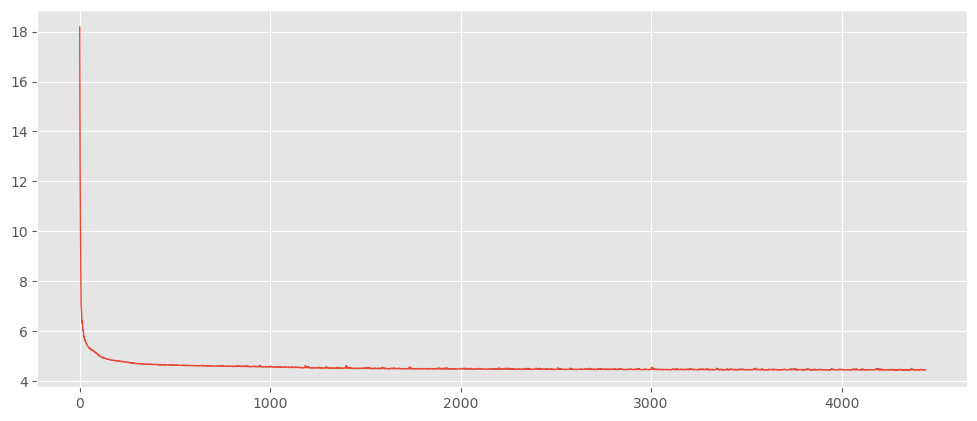

train_size:
21750
The following errors are calculated without the imputed observations!

[49, 99]


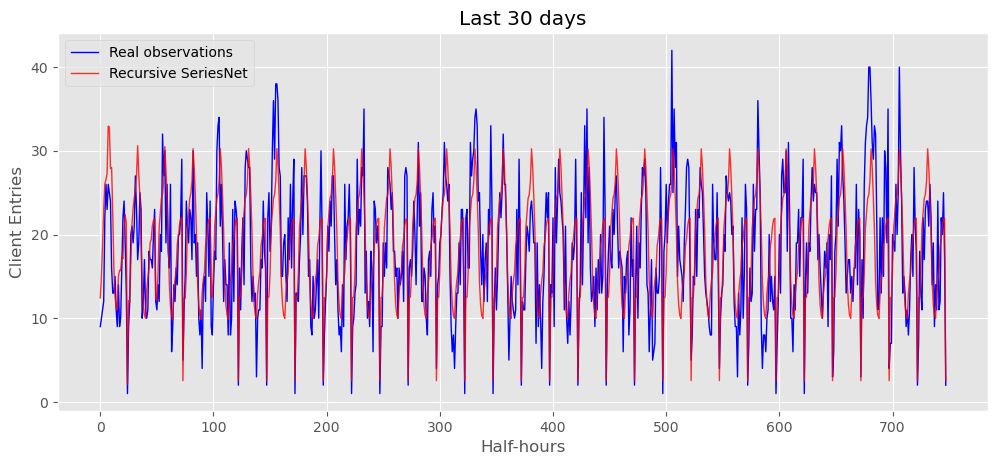

size of target and prediction:
748 748 [12.432451248168945, 15.114514350891113, 18.81555938720703, 22.967248916625977, 26.02919578552246, 26.56163215637207, 27.29277992248535, 32.94324493408203, 32.861019134521484, 27.879549026489258, 27.97979164123535, 22.49496078491211, 15.97136402130127, 12.610208511352539, 11.383298873901367, 10.963972091674805, 14.942770004272461, 15.734206199645996, 15.665399551391602, 17.406692504882812, 17.10529136657715, 20.844280242919922, 22.37428855895996, 21.356245040893555, 2.1075596809387207, 12.102895736694336, 11.94552230834961, 16.89666748046875, 21.22886085510254, 23.18634796142578, 24.388954162597656, 25.36754608154297, 27.02554702758789, 30.60989761352539, 27.229394912719727, 24.406280517578125, 19.396303176879883, 14.007962226867676, 11.434066772460938, 10.371026992797852, 9.99830436706543, 13.341718673706055, 14.765950202941895, 15.913203239440918, 19.01796531677246, 19.397050857543945, 21.04339027404785, 21.707611083984375, 21.91329574584961, 12

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 22499, 1)]   0                                            
__________________________________________________________________________________________________
conv1d_132 (Conv1D)             (None, 22499, 32)    64          input_7[0][0]                    
__________________________________________________________________________________________________
activation_48 (Activation)      (None, 22499, 32)    0           conv1d_132[0][0]                 
__________________________________________________________________________________________________
conv1d_134 (Conv1D)             (None, 22499, 1)     32          activation_48[0][0]              
____________________________________________________________________________________________

1/1 [==============================] - 1s 1s/step - loss: 35.9898 - mse: 3886.8962
Epoch 2/8000
1/1 [==============================] - 0s 91ms/step - loss: 20.1512 - mse: 1024.0576
Epoch 3/8000
1/1 [==============================] - 0s 88ms/step - loss: 10.8641 - mse: 235.8574
Epoch 4/8000
1/1 [==============================] - 0s 86ms/step - loss: 6.8389 - mse: 78.6113
Epoch 5/8000
1/1 [==============================] - 0s 88ms/step - loss: 6.3053 - mse: 65.7232
Epoch 6/8000
1/1 [==============================] - 0s 102ms/step - loss: 6.3242 - mse: 67.2514
Epoch 7/8000
1/1 [==============================] - 0s 91ms/step - loss: 6.2255 - mse: 65.7231
Epoch 8/8000
1/1 [==============================] - 0s 92ms/step - loss: 6.1574 - mse: 64.2222
Epoch 9/8000
1/1 [==============================] - 0s 93ms/step - loss: 6.0411 - mse: 61.5809
Epoch 10/8000
1/1 [==============================] - 0s 104ms/step - loss: 6.0100 - mse: 60.9761
Epoch 11/8000
1/1 [==============================] - 0

1/1 [==============================] - 0s 102ms/step - loss: 5.1800 - mse: 45.7386
Epoch 87/8000
1/1 [==============================] - 0s 94ms/step - loss: 5.1845 - mse: 45.7678
Epoch 88/8000
1/1 [==============================] - 0s 91ms/step - loss: 5.1619 - mse: 45.3365
Epoch 89/8000
1/1 [==============================] - 0s 98ms/step - loss: 5.1589 - mse: 45.4122
Epoch 90/8000
1/1 [==============================] - 0s 85ms/step - loss: 5.1583 - mse: 45.3196
Epoch 91/8000
1/1 [==============================] - 0s 89ms/step - loss: 5.1273 - mse: 44.7526
Epoch 92/8000
1/1 [==============================] - 0s 86ms/step - loss: 5.1142 - mse: 44.6320
Epoch 93/8000
1/1 [==============================] - 0s 96ms/step - loss: 5.1104 - mse: 44.5310
Epoch 94/8000
1/1 [==============================] - 0s 93ms/step - loss: 5.0853 - mse: 44.0712
Epoch 95/8000
1/1 [==============================] - 0s 90ms/step - loss: 5.0583 - mse: 43.7590
Epoch 96/8000
1/1 [==============================] - 

1/1 [==============================] - 0s 90ms/step - loss: 4.7697 - mse: 38.0503
Epoch 171/8000
1/1 [==============================] - 0s 90ms/step - loss: 4.7719 - mse: 38.0711
Epoch 172/8000
1/1 [==============================] - 0s 91ms/step - loss: 4.7675 - mse: 38.0674
Epoch 173/8000
1/1 [==============================] - 0s 93ms/step - loss: 4.7699 - mse: 38.0215
Epoch 174/8000
1/1 [==============================] - 0s 89ms/step - loss: 4.7690 - mse: 38.0246
Epoch 175/8000
1/1 [==============================] - 0s 80ms/step - loss: 4.7698 - mse: 37.9994
Epoch 176/8000
1/1 [==============================] - 0s 86ms/step - loss: 4.7648 - mse: 37.9539
Epoch 177/8000
1/1 [==============================] - 0s 94ms/step - loss: 4.7612 - mse: 37.9314
Epoch 178/8000
1/1 [==============================] - 0s 94ms/step - loss: 4.7626 - mse: 37.9231
Epoch 179/8000
1/1 [==============================] - 0s 94ms/step - loss: 4.7639 - mse: 37.9172
Epoch 180/8000
1/1 [=========================

1/1 [==============================] - 0s 97ms/step - loss: 4.6548 - mse: 36.9593
Epoch 255/8000
1/1 [==============================] - 0s 91ms/step - loss: 4.6544 - mse: 37.1378
Epoch 256/8000
1/1 [==============================] - 0s 89ms/step - loss: 4.6510 - mse: 36.9050
Epoch 257/8000
1/1 [==============================] - 0s 100ms/step - loss: 4.6479 - mse: 37.0107
Epoch 258/8000
1/1 [==============================] - 0s 95ms/step - loss: 4.6498 - mse: 36.9851
Epoch 259/8000
1/1 [==============================] - 0s 89ms/step - loss: 4.6495 - mse: 36.9175
Epoch 260/8000
1/1 [==============================] - 0s 96ms/step - loss: 4.6473 - mse: 37.0784
Epoch 261/8000
1/1 [==============================] - 0s 97ms/step - loss: 4.6501 - mse: 36.8583
Epoch 262/8000
1/1 [==============================] - 0s 103ms/step - loss: 4.6456 - mse: 37.0384
Epoch 263/8000
1/1 [==============================] - 0s 106ms/step - loss: 4.6435 - mse: 36.8940
Epoch 264/8000
1/1 [======================

1/1 [==============================] - 0s 89ms/step - loss: 4.6067 - mse: 36.5115
Epoch 339/8000
1/1 [==============================] - 0s 87ms/step - loss: 4.6093 - mse: 36.3081
Epoch 340/8000
1/1 [==============================] - 0s 89ms/step - loss: 4.6128 - mse: 36.6757
Epoch 341/8000
1/1 [==============================] - 0s 89ms/step - loss: 4.6130 - mse: 36.3229
Epoch 342/8000
1/1 [==============================] - 0s 92ms/step - loss: 4.6118 - mse: 36.6725
Epoch 343/8000
1/1 [==============================] - 0s 100ms/step - loss: 4.6063 - mse: 36.3228
Epoch 344/8000
1/1 [==============================] - 0s 94ms/step - loss: 4.6071 - mse: 36.4932
Epoch 345/8000
1/1 [==============================] - 0s 96ms/step - loss: 4.5982 - mse: 36.3751
Epoch 346/8000
1/1 [==============================] - 0s 97ms/step - loss: 4.6004 - mse: 36.2875
Epoch 347/8000
1/1 [==============================] - 0s 110ms/step - loss: 4.6007 - mse: 36.5242
Epoch 348/8000
1/1 [=======================

1/1 [==============================] - 0s 89ms/step - loss: 4.5877 - mse: 36.1303
Epoch 423/8000
1/1 [==============================] - 0s 104ms/step - loss: 4.5885 - mse: 36.3242
Epoch 424/8000
1/1 [==============================] - 0s 98ms/step - loss: 4.5863 - mse: 36.0560
Epoch 425/8000
1/1 [==============================] - 0s 92ms/step - loss: 4.5829 - mse: 36.2589
Epoch 426/8000
1/1 [==============================] - 0s 89ms/step - loss: 4.5869 - mse: 36.0473
Epoch 427/8000
1/1 [==============================] - 0s 91ms/step - loss: 4.5881 - mse: 36.3456
Epoch 428/8000
1/1 [==============================] - 0s 92ms/step - loss: 4.5881 - mse: 36.0650
Epoch 429/8000
1/1 [==============================] - 0s 87ms/step - loss: 4.5846 - mse: 36.2476
Epoch 430/8000
1/1 [==============================] - 0s 93ms/step - loss: 4.5807 - mse: 36.0790
Epoch 431/8000
1/1 [==============================] - 0s 99ms/step - loss: 4.5791 - mse: 36.0688
Epoch 432/8000
1/1 [========================

1/1 [==============================] - 0s 94ms/step - loss: 4.5595 - mse: 35.8577
Epoch 507/8000
1/1 [==============================] - 0s 95ms/step - loss: 4.5607 - mse: 36.0222
Epoch 508/8000
1/1 [==============================] - 0s 100ms/step - loss: 4.5671 - mse: 35.8876
Epoch 509/8000
1/1 [==============================] - 0s 91ms/step - loss: 4.5720 - mse: 36.3652
Epoch 510/8000
1/1 [==============================] - 0s 87ms/step - loss: 4.5850 - mse: 35.9482
Epoch 511/8000
1/1 [==============================] - 0s 88ms/step - loss: 4.5884 - mse: 36.7134
Epoch 512/8000
1/1 [==============================] - 0s 86ms/step - loss: 4.5809 - mse: 35.8843
Epoch 513/8000
1/1 [==============================] - 0s 93ms/step - loss: 4.5732 - mse: 36.2594
Epoch 514/8000
1/1 [==============================] - 0s 91ms/step - loss: 4.5660 - mse: 35.8456
Epoch 515/8000
1/1 [==============================] - 0s 82ms/step - loss: 4.5625 - mse: 35.9126
Epoch 516/8000
1/1 [========================

1/1 [==============================] - 0s 80ms/step - loss: 4.5436 - mse: 35.7537
Epoch 591/8000
1/1 [==============================] - 0s 82ms/step - loss: 4.5455 - mse: 35.7795
Epoch 592/8000
1/1 [==============================] - 0s 84ms/step - loss: 4.5453 - mse: 35.7875
Epoch 593/8000
1/1 [==============================] - 0s 85ms/step - loss: 4.5521 - mse: 35.8032
Epoch 594/8000
1/1 [==============================] - 0s 86ms/step - loss: 4.5530 - mse: 35.8591
Epoch 595/8000
1/1 [==============================] - 0s 84ms/step - loss: 4.5478 - mse: 35.7314
Epoch 596/8000
1/1 [==============================] - 0s 87ms/step - loss: 4.5518 - mse: 35.8544
Epoch 597/8000
1/1 [==============================] - 0s 84ms/step - loss: 4.5493 - mse: 35.6836
Epoch 598/8000
1/1 [==============================] - 0s 85ms/step - loss: 4.5441 - mse: 35.9203
Epoch 599/8000
1/1 [==============================] - 0s 93ms/step - loss: 4.5512 - mse: 35.6644
Epoch 600/8000
1/1 [=========================

KeyboardInterrupt: 

In [69]:
#%matplotlib notebook
# history of windows, is updated for each prediction
history = [x for x in train]
# save predictions
predictions = list()
for i in range(n_test_sets):
    # grid_search hyperparameters?
    # HERE
    
    # Time Series CROSS-VALIDATION
    # we don't need to retrain all the time though!
    print("walkforward expanding: %s" % (i+1))
    print("total expansions: %s" % (n_test_sets))
    # the model is trained and retrained for every number of n_output to predict
    if walkforward or i == 0:
        length = len(history)-1
        model = build_model(array(history), length)  
        train_size = len(history)
        print("train_size:")
        print(train_size)
    
    # predict the next n_output steps
    yhat_sequence = forecast(model, array(history), length)
    test_y = array(test[i*(n_output):(i+1)*(n_output)])
    #print("Test unnormalized error to compare with training loss:")  
    #print(mean_absolute_error(test_y.flatten(), yhat_sequence))
    
    # invert the scaling on predictions
    #yhat_sequence = invTransformTarget(scaler, yhat_sequence)
    
    # invert scaling for real values
    #test_y = invTransformTarget(scaler, test_y)
   
    # give the seasonal and trend components back
    if remove_components:
        # In development!!!
        predic1 = range(train_size, train_size+n_output)
        
        predic_halfday_cos = list(map(lambda x: cos(2*pi*x/(dataset_day/2.0)), predic1))
        predic_halfday_sin = list(map(lambda x: sin(2*pi*x/(dataset_day/2.0)), predic1))
        predic_day_cos = list(map(lambda x: cos(2*pi*x/dataset_day), predic1))
        predic_day_sin = list(map(lambda x: sin(2*pi*x/dataset_day), predic1))
        
        trend = reg_model.intercept_ + reg_model.coef_[0][0]*array(predic1)
        seas_day = reg_model.coef_[0][1]*array(predic_day_cos) + reg_model.coef_[0][2]*array(predic_day_sin)
        seas_halfday = reg_model.coef_[0][3]*array(predic_halfday_cos) + reg_model.coef_[0][4]*array(predic_halfday_sin)
        trend_seas = trend + seas_day  + seas_halfday
        
        sum_components = trend_seas
        yhat_sequence = [yhat_sequence[j]+sum_components[j] for j in range(n_output)]
        
        test_y_append = [test_y[j]-sum_components[j] for j in range(n_output)]
        #test_y_append = scaler.transform(array(test_y_append).reshape(n_output,1))
    

    # store the predictions for later results
    predictions.append(yhat_sequence)
    if remove_components:
        history = np.concatenate((history, test_y_append), axis=None)
    else:
        history = np.concatenate((history, test_y), axis=None)
        
    #RENORMALIZE: after appending the real values back to the training data normalize again to not introduce bias
    """
    if walkforward:
        length = len(history)
        arr_history = array(history)
        arr_history = invTransformTarget(scaler, arr_history.flatten())
        arr_history = arr_history.reshape(length,n_features)
        arr_history = normalize_train(scaler, arr_history)
        history = list(arr_history.reshape(length, n_features))
    """
    if imputed:
        list_idx = []
        for idx in imputed_idx:
            if train_size-1<idx<train_size+n_output:
                list_idx.append(idx - train_size)
        if list_idx:
            yhat_sequence = np.delete(yhat_sequence,  list_idx)
            test_y = np.delete(test_y,  list_idx)  
            print("The following errors are calculated without the imputed observations!\n")
    
    if compare_imputed:
        list_idx = []
        for idx in remove_idx:
            if train_size-1<idx<train_size+n_output:
                list_idx.append(idx - train_size)
        if list_idx:
            yhat_sequence = np.delete(yhat_sequence,  list_idx)
            test_y = np.delete(test_y,  list_idx) 
            print("The following errors are calculated without observations that do not fit into the wanted schedule!\n")
    print(list_idx)
    # plot each iteration 
    pyplot.title('Last 30 days')
    pyplot.plot(test_y, color="blue", label="Real observations")
    pyplot.plot(yhat_sequence, alpha=0.8, color="red", label="Recursive SeriesNet")
    pyplot.legend(loc="upper left")
    pyplot.xlabel("Half-hours")
    pyplot.ylabel("Client Entries")
    pyplot.show()
    
    print("size of target and prediction:")
    print(len(test_y), len(yhat_sequence), list(yhat_sequence))
    # Score only from the each modelled n_output
    rmse = sqrt(mean_squared_error(test_y, yhat_sequence))
    mae = mean(abs(test_y - yhat_sequence))
    mape = mean(abs(test_y - yhat_sequence) / test_y) * 100
    maape = mean_arctangent_absolute_percentage_error(test_y, yhat_sequence)
    print('Each test score, iteration %s \nRMSE %s' % (i+1, rmse))
    print('MAE %s' % (mae))
    #print('MAPE %s' % (mape))
    print('MAAPE %s \n' % (maape))
    
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image('model.png') 
# The question mark means that first dimension is not fixed in the graph and it can vary between run calls
print("The lower visualizations are only useful if walkforward (and multiple predictions) is employed")

In [311]:
#%tensorboard --logdir logs

In [312]:
"""
# invert scaling for overall real values
test_y = invTransformTarget(scaler, array(test).flatten())
        
# give the components back
if remove_components:
    test_y = test_y + components[-test_set*n_test_sets:]
    
if walkforward:
    # plot overall predictions
    pyplot.title('Recursive LSTM related model')
    pyplot.plot(test_y, color="blue", label="Real")
    pyplot.plot(array(predictions).flatten(), alpha=0.8, color="red", label="Recursive LSTM Prediction")
    pyplot.legend(loc="upper left")
    pyplot.xlabel("Half-hours")
    pyplot.ylabel("Receipts")
    pyplot.show()
"""

'\n# invert scaling for overall real values\ntest_y = invTransformTarget(scaler, array(test).flatten())\n        \n# give the components back\nif remove_components:\n    test_y = test_y + components[-test_set*n_test_sets:]\n    \nif walkforward:\n    # plot overall predictions\n    pyplot.title(\'Recursive LSTM related model\')\n    pyplot.plot(test_y, color="blue", label="Real")\n    pyplot.plot(array(predictions).flatten(), alpha=0.8, color="red", label="Recursive LSTM Prediction")\n    pyplot.legend(loc="upper left")\n    pyplot.xlabel("Half-hours")\n    pyplot.ylabel("Receipts")\n    pyplot.show()\n'

In [313]:
"""
# evaluate the predictions for each of the n_output steps

scores_rmse = list()
scores_mape = list()
scores_mae = list()
scores_maape = list()

predictions = array(predictions)
actual = array(test_y).reshape(predictions.shape[0], predictions.shape[1])
predicted = array(predictions)

# calculate the RMSE, MAPE, MAE and MAAPE for each step
for i in range(actual.shape[1]):
    
    #rmse, mape, mae and maape
    rmse = sqrt(mean_squared_error(actual[:, i], predicted[:, i]))
    mape = mean(abs(actual[:, i] - predicted[:, i]) / actual[:, i]) * 100
    mae = mean(abs(actual[:, i] - predicted[:, i]))
    maape = mean_arctangent_absolute_percentage_error(actual[:, i], predicted[:, i])

    
    # store the scores
    scores_rmse.append(rmse)
    scores_mape.append(mape)
    scores_mae.append(mae)
    scores_maape.append(maape)
# calculate the overall RMSE, MAPE, MAE and MAAPE (for all steps)
s_rmse = 0
s_mape = 0
s_mae = 0
s_maape = 0
for row in range(actual.shape[0]):
    for col in range(actual.shape[1]):
        s_rmse += (actual[row, col] - predicted[row, col]) ** 2
        s_mape += abs(actual[row, col] - predicted[row, col]) / actual[row, col]
        s_mae += abs(actual[row, col] - predicted[row, col])
        s_maape += arctan(abs((actual[row, col] - predicted[row, col]) / actual[row, col]))
        
score_rmse = sqrt(s_rmse / (actual.shape[0] * actual.shape[1]))
score_mape = 100 * s_mape / (actual.shape[0] * actual.shape[1])
score_mae = s_mae / (actual.shape[0] * actual.shape[1])
score_maape =  100 * s_maape / (actual.shape[0] * actual.shape[1]) 
"""

'\n# evaluate the predictions for each of the n_output steps\n\nscores_rmse = list()\nscores_mape = list()\nscores_mae = list()\nscores_maape = list()\n\npredictions = array(predictions)\nactual = array(test_y).reshape(predictions.shape[0], predictions.shape[1])\npredicted = array(predictions)\n\n# calculate the RMSE, MAPE, MAE and MAAPE for each step\nfor i in range(actual.shape[1]):\n    \n    #rmse, mape, mae and maape\n    rmse = sqrt(mean_squared_error(actual[:, i], predicted[:, i]))\n    mape = mean(abs(actual[:, i] - predicted[:, i]) / actual[:, i]) * 100\n    mae = mean(abs(actual[:, i] - predicted[:, i]))\n    maape = mean_arctangent_absolute_percentage_error(actual[:, i], predicted[:, i])\n\n    \n    # store the scores\n    scores_rmse.append(rmse)\n    scores_mape.append(mape)\n    scores_mae.append(mae)\n    scores_maape.append(maape)\n# calculate the overall RMSE, MAPE, MAE and MAAPE (for all steps)\ns_rmse = 0\ns_mape = 0\ns_mae = 0\ns_maape = 0\nfor row in range(actual.

In [314]:
"""
# Summarize the RMSE, MAPE, MAE and MAAPE scores
name = 'recursive LSTM'
s_scores_rmse = ', '.join(['%.1f' % s for s in scores_rmse])
s_scores_mape = ', '.join(['%.1f' % s for s in scores_mape])
s_scores_mae = ', '.join(['%.1f' % s for s in scores_mae])
s_scores_maape = ', '.join(['%.1f' % s for s in scores_maape])

print('%s: total_rmse [%.3f] \n RMSE %s' % (name, score_rmse, s_scores_rmse))
print('%s: total_mae [%.3f] \n MAE %s' % (name, score_mae, s_scores_mae))
print('%s: total_mape [%.3f] \n MAPE %s' % (name, score_mape, s_scores_mape))
print('%s: total_maape [%.3f] \n MAAPE %s' % (name, score_maape, s_scores_maape))

# Plotting of the scores for each step

forward_steps = list(range(1, test_set + 1))
pyplot.title('RMSE')
pyplot.plot(forward_steps, scores_rmse, marker='o')
pyplot.show()
pyplot.title('MAPE')
pyplot.plot(forward_steps, scores_mape, marker='o')
pyplot.show()
pyplot.title('MAE')
pyplot.plot(forward_steps, scores_mae, marker='o')
pyplot.show()
pyplot.title('MAAPE')
pyplot.plot(forward_steps, scores_maape, marker='o')
pyplot.show()
"""

"\n# Summarize the RMSE, MAPE, MAE and MAAPE scores\nname = 'recursive LSTM'\ns_scores_rmse = ', '.join(['%.1f' % s for s in scores_rmse])\ns_scores_mape = ', '.join(['%.1f' % s for s in scores_mape])\ns_scores_mae = ', '.join(['%.1f' % s for s in scores_mae])\ns_scores_maape = ', '.join(['%.1f' % s for s in scores_maape])\n\nprint('%s: total_rmse [%.3f] \n RMSE %s' % (name, score_rmse, s_scores_rmse))\nprint('%s: total_mae [%.3f] \n MAE %s' % (name, score_mae, s_scores_mae))\nprint('%s: total_mape [%.3f] \n MAPE %s' % (name, score_mape, s_scores_mape))\nprint('%s: total_maape [%.3f] \n MAAPE %s' % (name, score_maape, s_scores_maape))\n\n# Plotting of the scores for each step\n\nforward_steps = list(range(1, test_set + 1))\npyplot.title('RMSE')\npyplot.plot(forward_steps, scores_rmse, marker='o')\npyplot.show()\npyplot.title('MAPE')\npyplot.plot(forward_steps, scores_mape, marker='o')\npyplot.show()\npyplot.title('MAE')\npyplot.plot(forward_steps, scores_mae, marker='o')\npyplot.show()